---
<div align="center">
<h1><span style="color:red;">Surfing the Bitcoin Waves: Comprehensive Trend Forecasting with Various Trader Types</span></h1>
</div>

---
# Authors:
<h3>
<ol>
  <li>Can Ali Ateş - Hacettepe University, Turkey</li>
  <li>Emre Çoban - Hacettepe University, Turkey</li>
</ol>   
</h3>

---
# Problem Definition:
<b></b>
<div style="font-size: 18px;">
    <p>The goal of this project is to thoroughly analyze trends in Bitcoin by studying the behaviors of three key groups:</p>
    <ol>
        <li>Large holders of cryptocurrency (referred to as "whales")</li>
        <li>Influential participants in the stock market (widely recognized as “top traders”)</li>
        <li>Automated trading algorithms (commonly known as "bots")</li>
    </ol>
</div>

---
# Table of Contents

## 1. [Dataset](#1)
    
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>1.1. [Data Explanation](#1.1)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>1.2. [Data Visualization](#1.2)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>1.3. [Data Frame Creation](#1.3)
    
## 2. [Exploratory Data Analysis and Preprocessing](#2)

### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>2.1. [Get Insights](#2.1)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>2.2. [Handling Missing Values](#2.2)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>2.3. [Outlier Analysis](#2.3)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>2.4. [Feature Selection and Engineering](#2.4)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>2.5. [Splitting Data Into Train, Validation and Test](#2.5)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>2.6. [Scaling Data](#2.6)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>2.7. [Splitting Target and Input Feature](#2.7)

## 3. [Methodology](#3)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.1. [Machine Learning Models](#3.1)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.1.1 [Linear Regression Model](#3.1.1)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.1.2 [Random Forest Regression Model](#3.1.2)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.1.3 [XGBoost Regression Model](#3.1.3)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.2. [Traditional Forecasting Models](#3.2)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.2.1 [SARIMAX Model](#3.2.1)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.2.2 [Prophet Model](#3.2.2)
### <sub>&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.3. [Deep Learning Models](#3.3)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.3.1 [LSTM-FCN Model](#3.3.1)
#### <sub>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</sub>3.3.2 [FCN Model](#3.3.2)

In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Methodology
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.modules.transformer import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from tsai.imports import *
from tsai.models.layers import *

# Warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

Importing plotly failed. Interactive plots will not work.


<a id=1></a>
# 1. Dataset

<a id=1.1></a>
## 1.1 Data Explanation

The dataset is a combination of 8 different CSV files.

1. **klines:** The dataset has “Open”, “Close”, “High” and “Low” price features for the Bitcoin stock market.
2. **botTracker:** The dataset has an “estimatedBotCount” feature which indicates the prediction of bot activity based on the searching for frequently occurring unique order sizes.
3. **binanceGlobalAccounts:** The dataset has “Long”, “Short”, and “Ratio of Short and Long” features that represent the total number of accounts that are long or short strategy on Binance.
4. **binanceTopTraderAccounts:** The dataset has “Long”, “Short”, and “Ratio of Short and Long” features that represent the total number of top trader accounts (top %20) that are long or short strategies on Binance.
5. **binanceTopTraderPositions:** The dataset has “Long”, “Short”, and “Ratio of Short and Long” features that represent the total number of top traders positions (top %20) that are long or short strategy on Binance.
6. **binanceWhaleRetailDelta:** The dataset has a “WhaleRetailPositionDelta” feature that indicates the difference between the percentage of long positions held by top trader accounts ("whales") and the percentage of long positions held by global accounts ("retail").
7. **buyVolume:** The dataset has a “BuyingOrderQuantity” feature that indicates the quantity of buying orders executed during a specified period.
8. **sellVolume:** The dataset has a “SellingOrderQuantity” feature that indicates the quantity of selling orders executed during a specified period.

In [2]:
# Define the CSV files
data_files = ["klines", "botTracker", "binanceGlobalAccounts", "binanceTopTraderAccounts", 
              "binanceTopTraderPositions", "binanceWhaleDelta", "buyVolume", "sellVolume"]

<a id=1.2></a>
## 1.2 Data Visualization

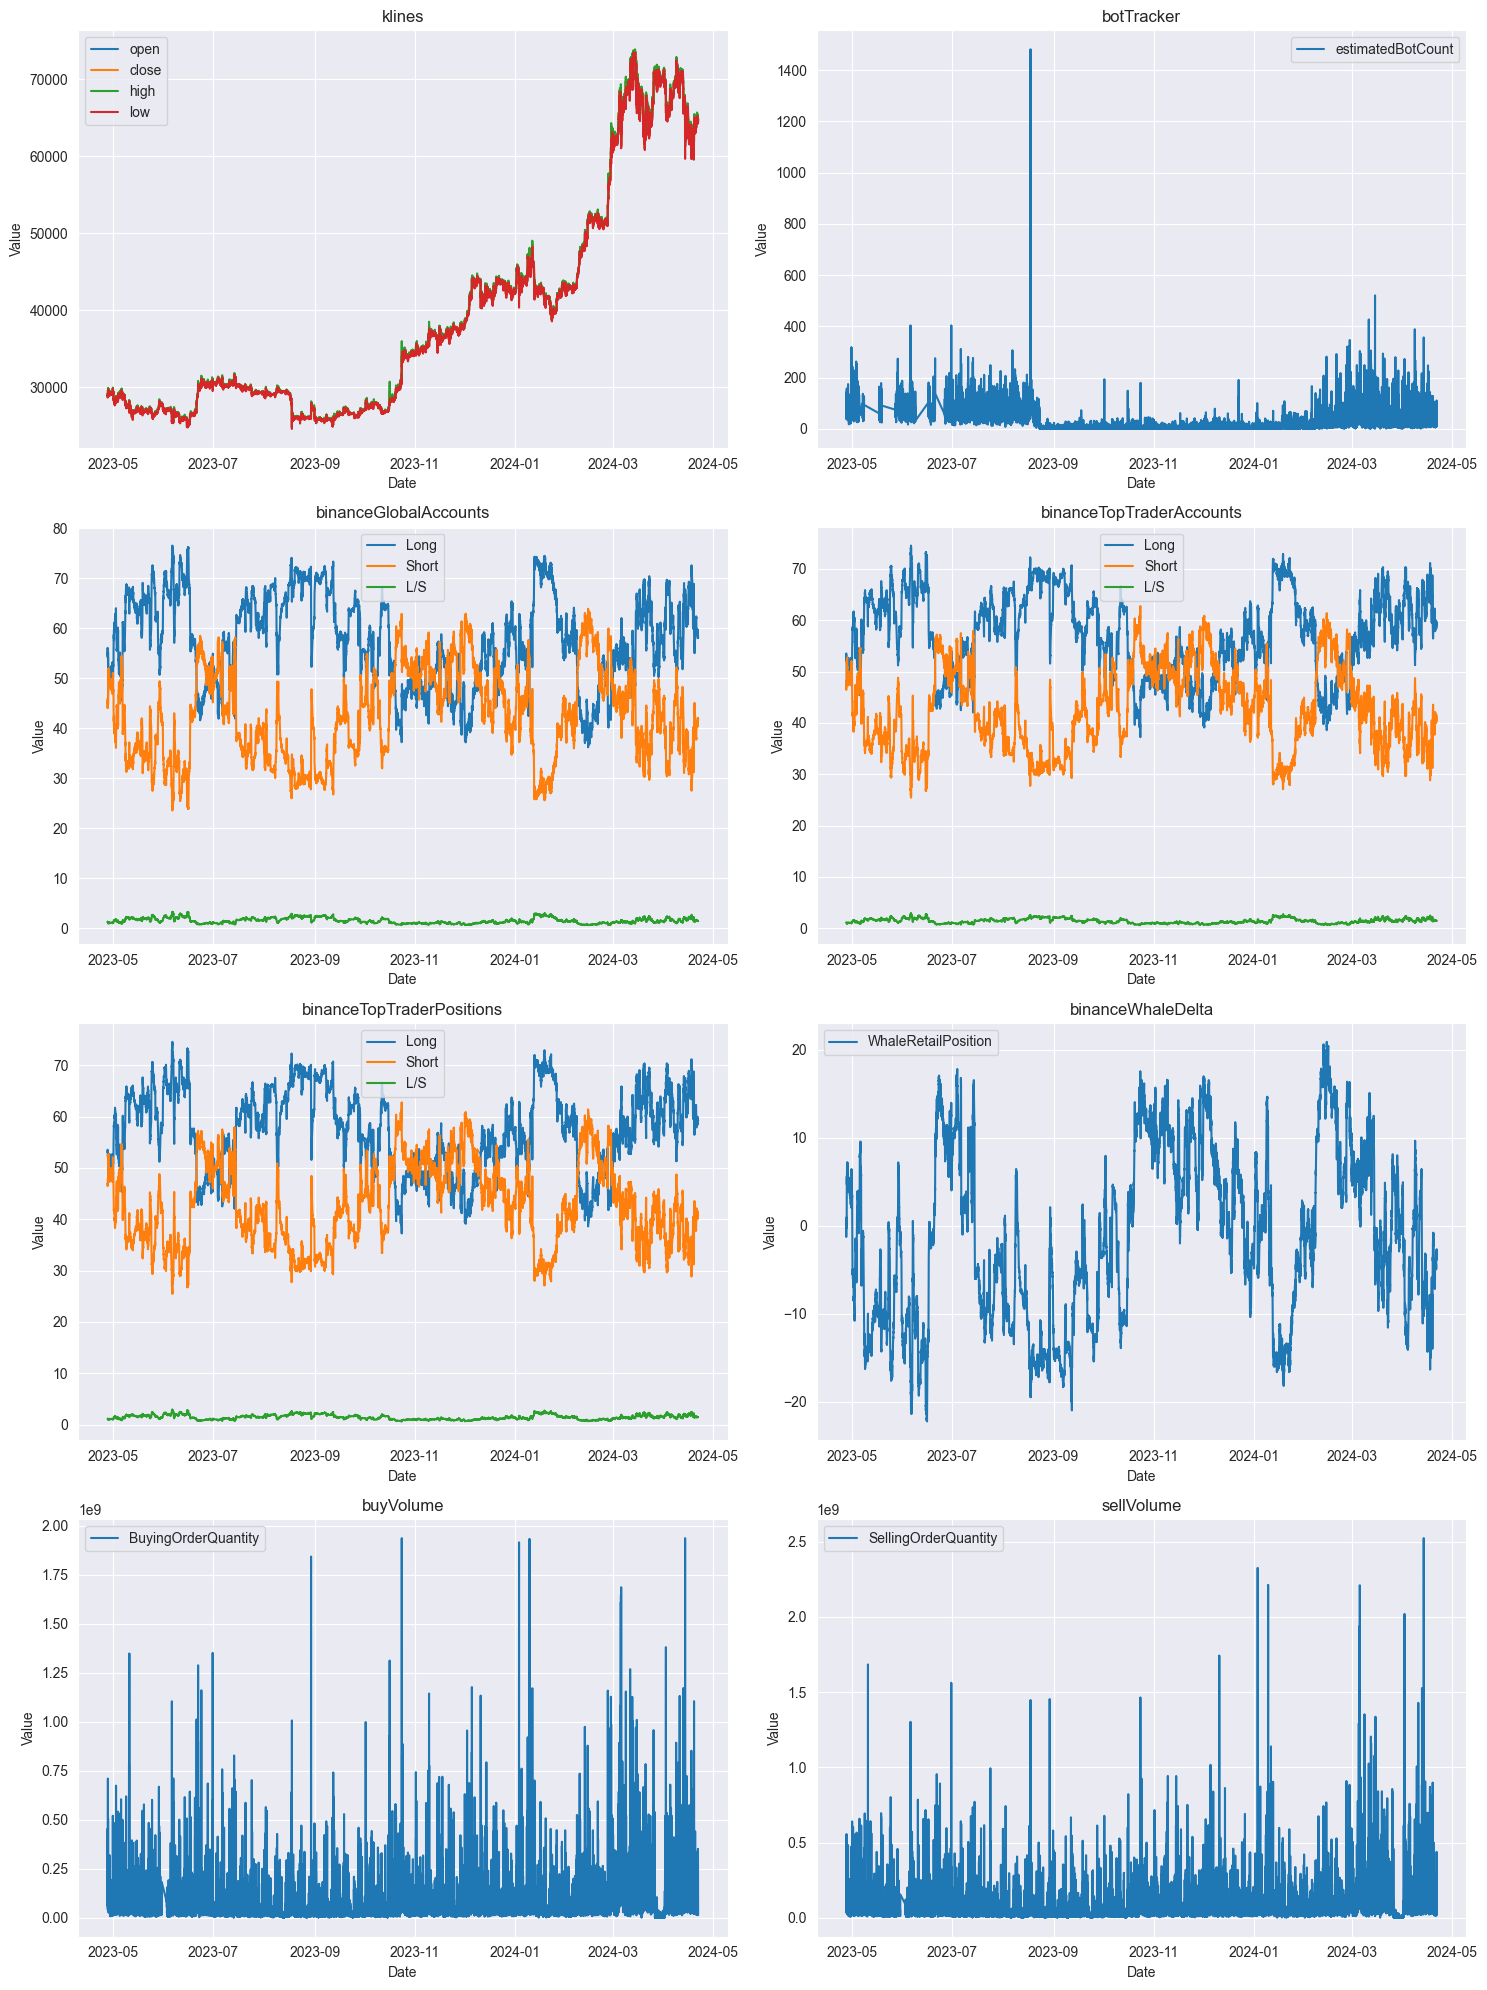

In [3]:
def plot_csv(filename:str, ax:plt.axes):
    # Read the CSV file
    data = pd.read_csv(f"data/{filename}15mins.csv")
    # Convert 'Date' column to datetime
    data['Date'] = pd.to_datetime(data['Date'])
    # Plot the data
    for column in data.columns[1:]:
        ax.plot(data['Date'], data[column], label=column)
    ax.set_title(f'{filename}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

def plot_data(files:list):
    # Create a subplot grid to plot all data files
    fig, axs = plt.subplots(4, 2, figsize=(15, 20))
    # Iterate over each data file and plot them into subplot grid
    for i, csv_file in enumerate(files):
        plot_csv(filename=csv_file, ax=axs[i // 2, i % 2])
    # Display the plots
    plt.tight_layout()
    plt.show()

plot_data(data_files)

<a id=1.3></a>
## 1.3 Data Frame Creation

In [4]:
# Create a data frame that holds all information in data files
bitcoin_df = pd.DataFrame(columns=['Date'])

# Merge files based on common column
for file in data_files:
    print(file)
    temp_df = pd.read_csv(f"data/{file}15mins.csv")
    temp_df['Date'] = pd.to_datetime(temp_df['Date'])
    bitcoin_df = pd.merge(bitcoin_df, temp_df, on='Date', how="outer")

# Display the data frame
bitcoin_df.set_index("Date", inplace=True)
display(bitcoin_df)

klines
botTracker
binanceGlobalAccounts
binanceTopTraderAccounts
binanceTopTraderPositions
binanceWhaleDelta
buyVolume
sellVolume


,open,close,high,low,estimatedBotCount,Long_x,Short_x,L/S_x,Long_y,Short_y,L/S_y,Long,Short,L/S,WhaleRetailPosition,BuyingOrderQuantity,SellingOrderQuantity
Date,,,,,,,,,,,,,,,,,
2023-04-27 10:15:00+00:00,28959.3,28937.2,29000.0,28930.8,48.0,55.07,44.93,1.2257,53.02,46.98,1.1286,53.02,46.98,1.1286,-0.17,4.311050e+07,5.464228e+07
2023-04-27 10:30:00+00:00,28937.2,29006.8,29019.4,28937.0,44.0,55.04,44.96,1.2242,53.01,46.99,1.1281,53.01,46.99,1.1281,-0.12,5.897624e+07,3.443539e+07
2023-04-27 10:45:00+00:00,29006.8,28981.9,29029.0,28943.0,65.0,55.12,44.88,1.2282,53.05,46.95,1.1299,53.05,46.95,1.1299,-0.23,5.094587e+07,5.778385e+07
2023-04-27 11:00:00+00:00,28981.9,29077.6,29139.2,28960.0,53.0,55.18,44.82,1.2311,53.05,46.95,1.1299,53.05,46.95,1.1299,-0.30,2.054326e+08,1.598568e+08
2023-04-27 11:15:00+00:00,29077.6,29035.3,29084.6,29025.4,119.0,56.03,43.97,1.2743,53.52,46.48,1.1515,53.52,46.48,1.1515,-1.24,6.229194e+07,8.039308e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-21 17:45:00+00:00,64721.3,64793.0,64859.0,64713.4,20.0,58.47,41.53,1.4079,59.31,40.69,1.4576,59.31,40.69,1.4576,-3.10,4.129480e+07,3.586159e+07
2024-04-21 18:00:00+00:00,64793.0,64819.8,64847.7,64600.0,47.0,58.35,41.65,1.4010,59.24,40.76,1.4534,59.24,40.76,1.4534,-2.98,4.500680e+07,7.044362e+07
2024-04-21 18:15:00+00:00,64819.8,64810.0,64819.8,64687.7,39.0,58.17,41.83,1.3906,59.21,40.79,1.4516,59.21,40.79,1.4516,-2.68,3.674641e+07,4.003513e+07


<a id=2></a>
# 2. Exploratory Data Analysis and Preprocessing

In [5]:
# Rename the columns for naming convention
bitcoin_df.rename(columns={"Long_x": "globalAccounts_Long",
                  "Short_x": "globalAccounts_Short",
                  "L/S_x": "globalAccounts_LS",
                  "Long_y": "topTraderAccounts_Long",
                  "Short_y": "topTraderAccounts_Short",
                  "L/S_y": "topTraderAccounts_LS",
                  "Long": "topTraderPositions_Long",
                  "Short": "topTraderPositions_Short",
                  "L/S": "topTraderPositions_LS"},
                  inplace=True)

display(bitcoin_df.head())

,open,close,high,low,estimatedBotCount,globalAccounts_Long,globalAccounts_Short,globalAccounts_LS,topTraderAccounts_Long,topTraderAccounts_Short,topTraderAccounts_LS,topTraderPositions_Long,topTraderPositions_Short,topTraderPositions_LS,WhaleRetailPosition,BuyingOrderQuantity,SellingOrderQuantity
Date,,,,,,,,,,,,,,,,,
2023-04-27 10:15:00+00:00,28959.3,28937.2,29000.0,28930.8,48.0,55.07,44.93,1.2257,53.02,46.98,1.1286,53.02,46.98,1.1286,-0.17,4.311050e+07,5.464228e+07
2023-04-27 10:30:00+00:00,28937.2,29006.8,29019.4,28937.0,44.0,55.04,44.96,1.2242,53.01,46.99,1.1281,53.01,46.99,1.1281,-0.12,5.897624e+07,3.443539e+07
2023-04-27 10:45:00+00:00,29006.8,28981.9,29029.0,28943.0,65.0,55.12,44.88,1.2282,53.05,46.95,1.1299,53.05,46.95,1.1299,-0.23,5.094587e+07,5.778385e+07
2023-04-27 11:00:00+00:00,28981.9,29077.6,29139.2,28960.0,53.0,55.18,44.82,1.2311,53.05,46.95,1.1299,53.05,46.95,1.1299,-0.30,2.054326e+08,1.598568e+08
2023-04-27 11:15:00+00:00,29077.6,29035.3,29084.6,29025.4,119.0,56.03,43.97,1.2743,53.52,46.48,1.1515,53.52,46.48,1.1515,-1.24,6.229194e+07,8.039308e+07


<a id=2.1></a>
## 2.1 Get Insights 

In [6]:
# Get data frame info
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34645 entries, 2023-04-27 10:15:00+00:00 to 2024-04-21 18:45:00+00:00
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   open                      34556 non-null  float64
 1   close                     34556 non-null  float64
 2   high                      34556 non-null  float64
 3   low                       34556 non-null  float64
 4   estimatedBotCount         31376 non-null  float64
 5   globalAccounts_Long       34535 non-null  float64
 6   globalAccounts_Short      34535 non-null  float64
 7   globalAccounts_LS         34535 non-null  float64
 8   topTraderAccounts_Long    34532 non-null  float64
 9   topTraderAccounts_Short   34532 non-null  float64
 10  topTraderAccounts_LS      34532 non-null  float64
 11  topTraderPositions_Long   34532 non-null  float64
 12  topTraderPositions_Short  34532 non-null  float64
 13  topTraderPosit

In [7]:
# Describe the data frame
bitcoin_df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
open,34556.0,3.870601e+04,1.389279e+04,24803.0000,2.747807e+04,3.384460e+04,4.366677e+04,7.369010e+04
close,34556.0,3.870723e+04,1.389374e+04,24804.1000,2.747805e+04,3.384505e+04,4.366707e+04,7.369010e+04
high,34556.0,3.877141e+04,1.393646e+04,24917.9000,2.752205e+04,3.391520e+04,4.372985e+04,7.388140e+04
low,34556.0,3.863796e+04,1.384659e+04,24581.0000,2.743295e+04,3.377965e+04,4.359468e+04,7.348000e+04
estimatedBotCount,31376.0,3.178120e+01,3.906006e+01,0.0000,4.000000e+00,1.500000e+01,5.025000e+01,1.481000e+03
globalAccounts_Long,34535.0,5.763517e+01,8.930339e+00,36.1500,5.071000e+01,5.773000e+01,6.512500e+01,7.649000e+01
globalAccounts_Short,34535.0,4.236483e+01,8.930339e+00,23.5100,3.487500e+01,4.227000e+01,4.929000e+01,6.385000e+01
globalAccounts_LS,34535.0,1.472252e+00,5.436524e-01,0.5662,1.028800e+00,1.365700e+00,1.867400e+00,3.253500e+00
topTraderAccounts_Long,34532.0,5.730141e+01,7.819026e+00,37.2300,5.098000e+01,5.768000e+01,6.354000e+01,7.456000e+01
topTraderAccounts_Short,34532.0,4.269859e+01,7.819026e+00,25.4400,3.646000e+01,4.232000e+01,4.902000e+01,6.277000e+01


<a id=2.2></a>
## 2.2 Handling Missing Values 

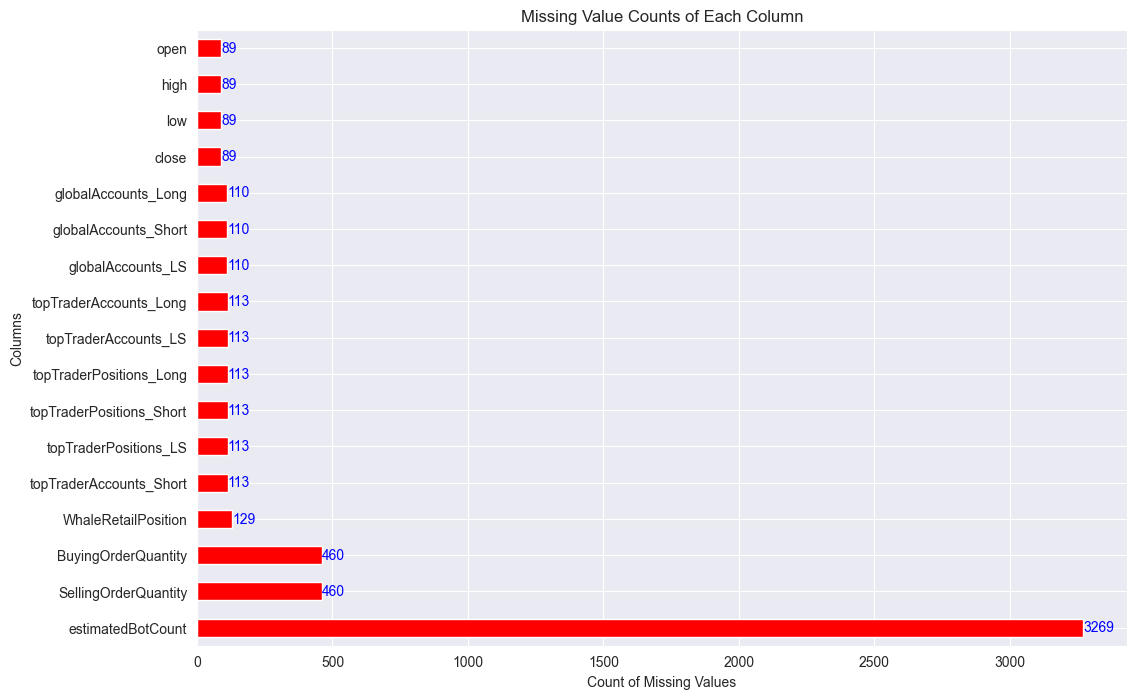

In [8]:
def visualize_missing_value_counts(df=bitcoin_df):
    # Plot bar chart to display missing value counts of features
    plt.figure(figsize=(12, 8))
    missing_values = df.isnull().sum().sort_values(ascending=False)
    missing_values.plot(kind='barh', color='red')
    
    # Adding instance count on the graph
    for i, v in enumerate(missing_values):
        plt.text(v + 1, i, str(v), color='blue', va='center')
    
    # Plot NaN value graph
    plt.xlabel('Count of Missing Values')
    plt.ylabel('Columns')
    plt.title('Missing Value Counts of Each Column')
    plt.show()

visualize_missing_value_counts()

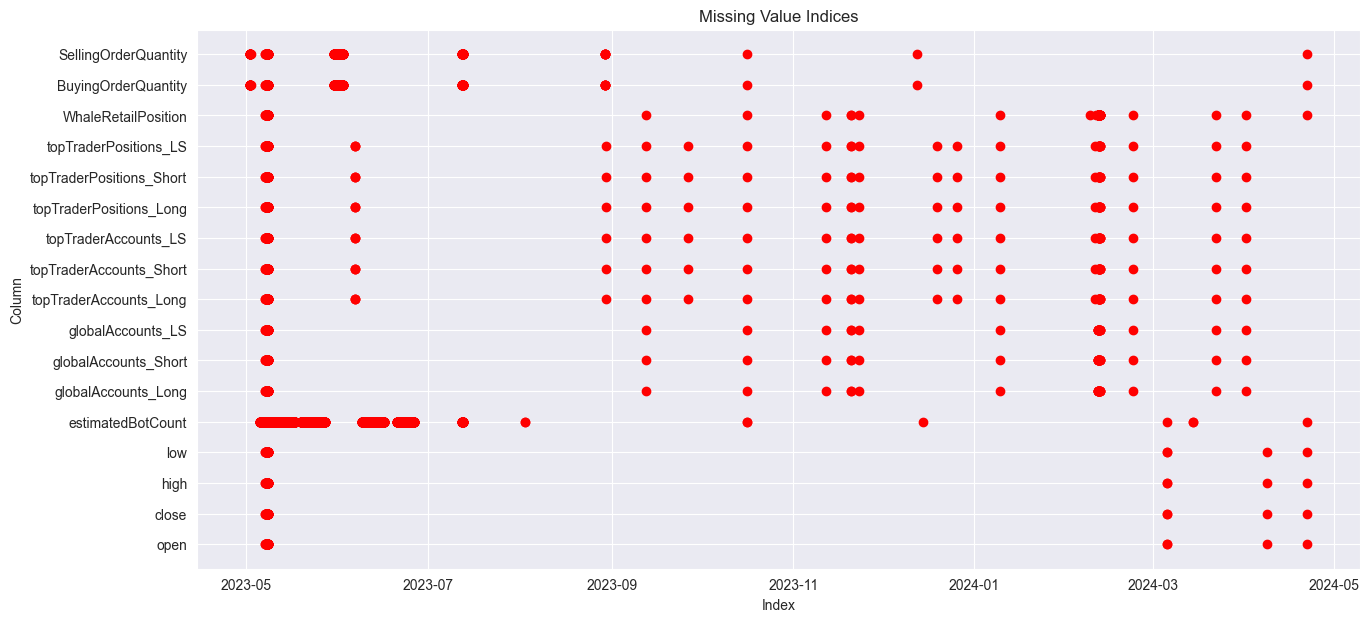

In [9]:
def visualize_missing_value_indexes(df=bitcoin_df):
    # Create a DataFrame to store missing value indices
    missing_indices = df.isnull().astype(int)
    
    # Plot missing value indices
    plt.figure(figsize=(15, 7))
    y_missing, y_non_missing = [], []
    for i, column in enumerate(df.columns):
        missing_values = missing_indices[column][missing_indices[column] == 1].index
        non_missing_values = missing_indices[column][missing_indices[column] == 0].index
        y_missing.extend([i] * len(missing_values))
        y_non_missing.extend([i + 0.5] * len(non_missing_values))
        plt.scatter(missing_values, [i] * len(missing_values), marker='o', color='red', label='Missing Values' if i == 0 else None)
    
    plt.yticks(range(len(df.columns)), df.columns)
    plt.title('Missing Value Indices')
    plt.xlabel('Index')
    plt.ylabel('Column')
    plt.show()

visualize_missing_value_indexes()

- **The API returns NaN when the system does not detect any bot at this interval, therefore we will fill the NaN values with 0 in the estimatedBotCount**
- **Most of the features have same consecutive NaN values at the end, therefore drop these rows**
- **Impute remain features with the linear interpolation**

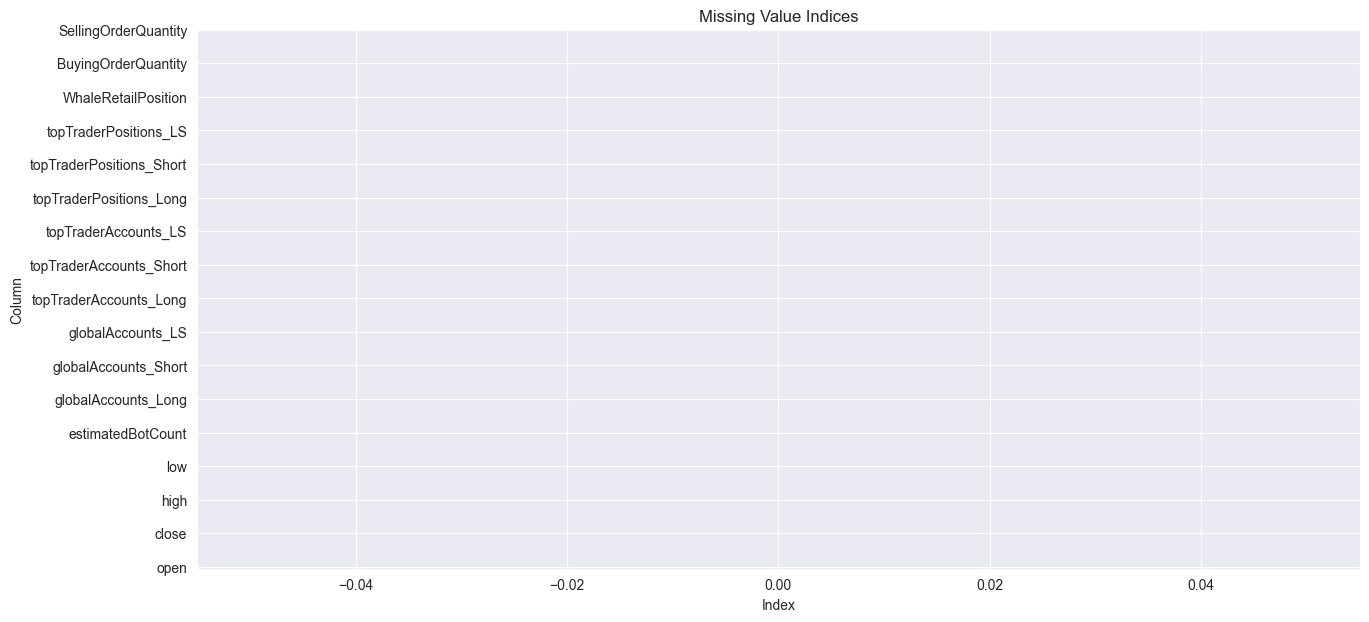

In [10]:
# Impute the NaN values of estimatedBotCount with 0
bitcoin_df.fillna({'estimatedBotCount': 0}, inplace=True)
# Choose the NaN values at the end using "open" feature as guidance
bitcoin_df.dropna(subset=["open"], inplace=True)
# Impute remain NaN values with linear interpolation
bitcoin_df.interpolate(method="linear", axis=0, inplace=True)

# Display NaN value counts after missing value handling
visualize_missing_value_indexes()

<a id=2.3></a>
## 2.3 Outlier Analysis

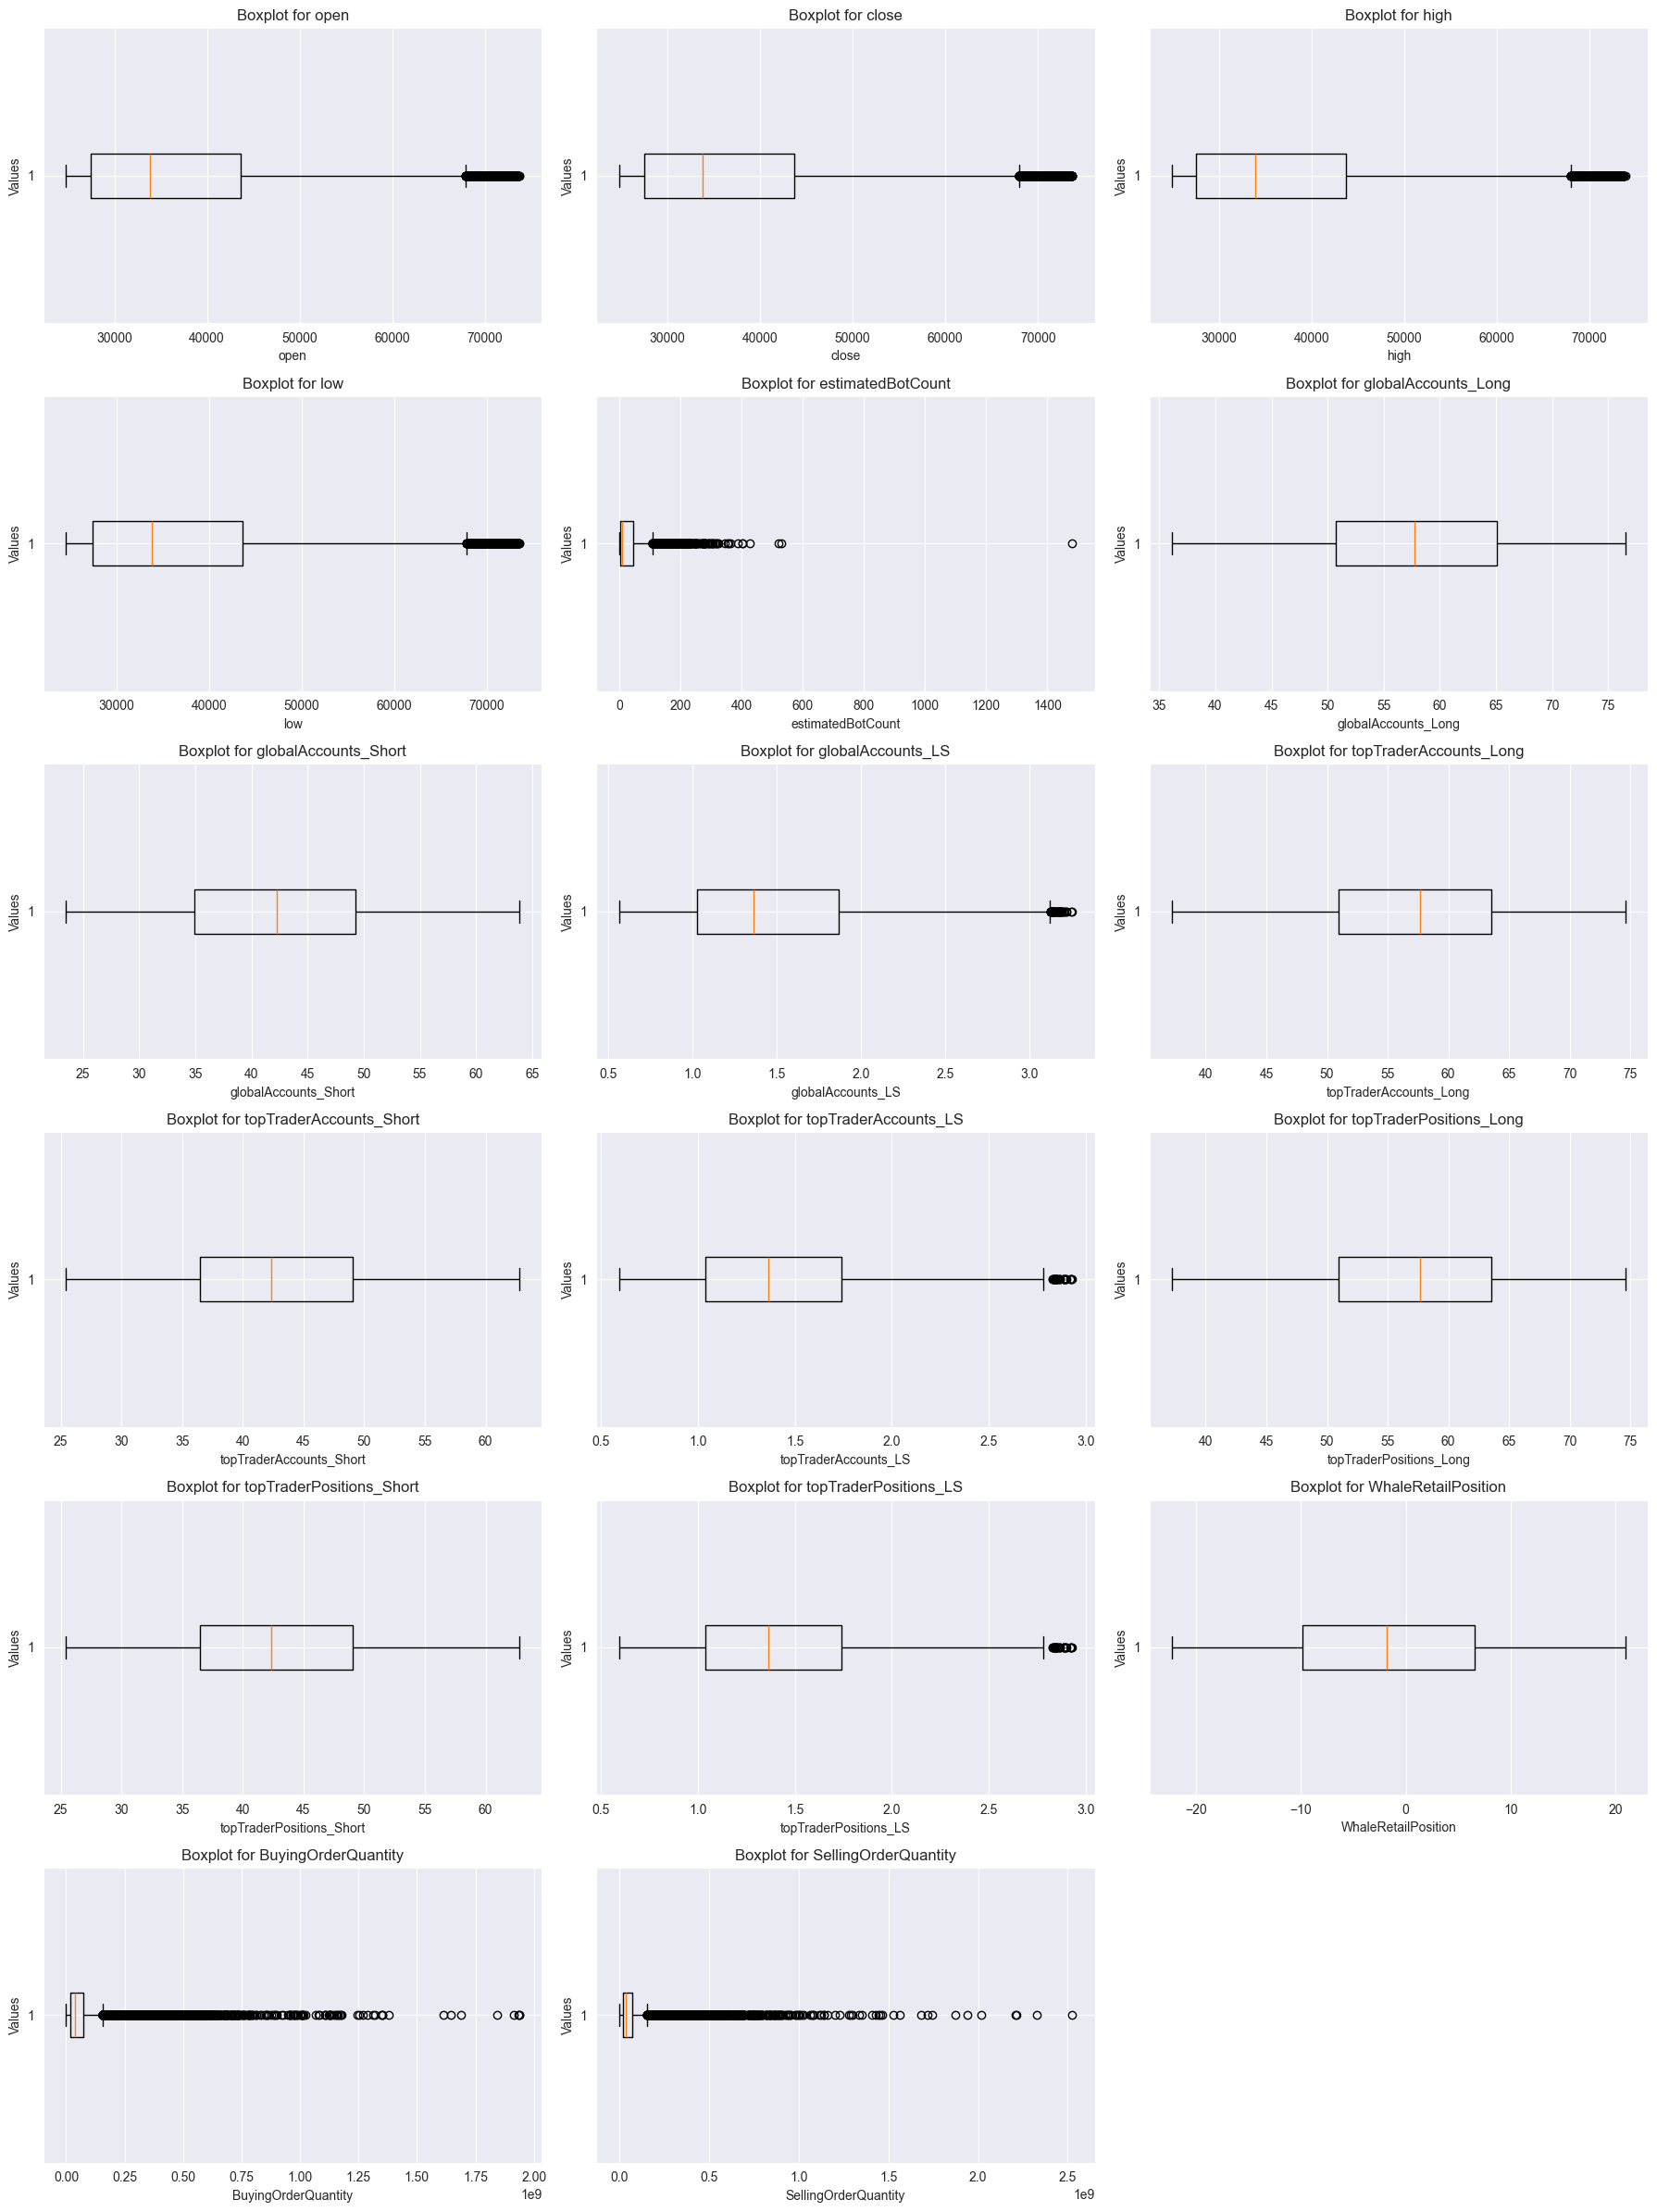

In [11]:
# Create a 6x3 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 24))

# Flatten the axes array
axes = axes.flatten()

# Plot each column in a separate subplot
for i, column in enumerate(bitcoin_df.columns):
    axes[i].boxplot(bitcoin_df[column], vert=False)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Values')
    axes[i].set_title(f'Boxplot for {column}')

# Hide any extra subplots
for j in range(len(bitcoin_df.columns), len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

**The boxplot figure demonstrated that some of the features have outliers but data that used for the project is time-series so, these points can be extrema. However, these outliers provide valuable insights into extreme market conditions and trading behaviors, while respecting the inherent volatility of cryptocurrency markets. Therefore, the outliers will be protected instead of dropping or smoothing them.**

<a id=2.4></a>
## 2.4 Feature Selection and Engineering

In [12]:
# Drop the features that have LS feature which represent the Long-Short ratio
bitcoin_df.drop(columns=["globalAccounts_Long", "globalAccounts_Short",
                         "topTraderAccounts_Long", "topTraderAccounts_Short",
                         "topTraderPositions_Long", "topTraderPositions_Short"], inplace=True)

# Check first 5 row of feature selected dataframe
display(bitcoin_df.head())

,open,close,high,low,estimatedBotCount,globalAccounts_LS,topTraderAccounts_LS,topTraderPositions_LS,WhaleRetailPosition,BuyingOrderQuantity,SellingOrderQuantity
Date,,,,,,,,,,,
2023-04-27 10:15:00+00:00,28959.3,28937.2,29000.0,28930.8,48.0,1.2257,1.1286,1.1286,-0.17,4.311050e+07,5.464228e+07
2023-04-27 10:30:00+00:00,28937.2,29006.8,29019.4,28937.0,44.0,1.2242,1.1281,1.1281,-0.12,5.897624e+07,3.443539e+07
2023-04-27 10:45:00+00:00,29006.8,28981.9,29029.0,28943.0,65.0,1.2282,1.1299,1.1299,-0.23,5.094587e+07,5.778385e+07
2023-04-27 11:00:00+00:00,28981.9,29077.6,29139.2,28960.0,53.0,1.2311,1.1299,1.1299,-0.30,2.054326e+08,1.598568e+08
2023-04-27 11:15:00+00:00,29077.6,29035.3,29084.6,29025.4,119.0,1.2743,1.1515,1.1515,-1.24,6.229194e+07,8.039308e+07


<a id=2.5></a>
## 2.5 Splitting Data Into Train, Validation and Test

In [13]:
def train_val_split(df, train_ratio = 0.9, val_ratio = 0.05):

    # Determine the sizes of each set
    total_samples = len(df)
    train_size = int(total_samples * train_ratio)  # 90% for training
    val_size = int(total_samples * val_ratio)   # 5% for validation
    test_size = total_samples - train_size - val_size # 5% for testing

    # Split the DataFrame
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:train_size + val_size]
    test_df = df.iloc[train_size + val_size:]

    return train_df, val_df, test_df


bitcoin_df.index = pd.to_datetime(bitcoin_df.index)
bitcoin_df = bitcoin_df.asfreq('15min')
bitcoin_df.interpolate(method="linear", axis=0, inplace=True)  # NaN values due to mismatch in time frequency using interpolation (35 per feature)

train_df_original, val_df_original, test_df_original = train_val_split(bitcoin_df)

print(f"Training set size: {len(train_df_original)}")
print(f"Validation set size: {len(val_df_original)}")
print(f"Test set size: {len(test_df_original)}")

Training set size: 31134
Validation set size: 1729
Test set size: 1731


<a id=2.6></a>
## 2.6 Scaling Data

In [14]:
# Extract column names
column_names = train_df_original.columns

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the data
train_scaled = scaler.fit_transform(train_df_original)
val_scaled = scaler.transform(val_df_original)
test_scaled = scaler.transform(test_df_original)

# Create new DataFrames with scaled data and original column names
train_df = pd.DataFrame(train_scaled, columns=column_names, index=train_df_original.index)
val_df = pd.DataFrame(val_scaled, columns=column_names, index=val_df_original.index)
test_df = pd.DataFrame(test_scaled, columns=column_names, index=test_df_original.index)

<a id=2.7></a>
## 2.7 Splitting Target and Input Features

In [15]:
# Training set
X_train = train_df.drop(columns=['close'])
y_train = train_df['close']

# Validation set
X_val = val_df.drop(columns=['close'])
y_val = val_df['close']

# Test set
X_test = test_df.drop(columns=['close'])
y_test = test_df['close']

In [16]:
X_train.index[0],  X_val.index[0], X_test.index[0]

(Timestamp('2023-04-27 10:15:00+0000', tz='UTC'),
 Timestamp('2024-03-16 17:45:00+0000', tz='UTC'),
 Timestamp('2024-04-03 18:00:00+0000', tz='UTC'))

<a id=3></a>
# 3. METHODOLOGY

In [17]:
# Window generator
def sliding_window_generator(x_df, y_df, window_size, step_size, forecast_horizon=1):
    """
    Generate sliding windows from two pandas DataFrames.

    Args:
        x_df (pandas.DataFrame): Input DataFrame.
        y_df (pandas.DataFrame): Output DataFrame.
        window_size (int): Size of the sliding window.
        step_size (int): Step size for sliding the window.
        forecast_horizon (int): Number of steps to forecast into the future.

    Returns:
        tuple: Tuple containing two numpy.ndarrays:
               - seq_x: Input sequences
               - seq_y: Corresponding output sequences
    """
    x_data = x_df.values
    y_data = y_df.values
    num_samples = len(x_data)
    seq_x, seq_y = [], []
    for i in range(0, num_samples - window_size - forecast_horizon + 1, step_size):
        x_window = x_data[i:i + window_size]
        y_window = y_data[i + window_size:i + window_size + forecast_horizon]
        seq_x.append(x_window)  # Input sequence
        seq_y.append(y_window)  # Corresponding output
    return np.array(seq_x), np.array(seq_y)


# For drawing predictions vs truth graph.
def plot_predictions(truth, preds):
    plt.figure(figsize=(10, 6))
    plt.plot(truth, label='Actual', color='blue')
    plt.plot(preds, label='Predicted', color='red')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Test Predictions vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()


def evaluate_predictions(model_name, truth, preds):
    # Convert inputs to numpy arrays
    truth = np.array(truth)
    preds = np.array(preds)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(truth, preds))

    # Calculate MAE
    mae = mean_absolute_error(truth, preds)

    # Calculate R2
    r2 = r2_score(truth, preds)

    # Print the evaluation metrics
    print(f"Evaluation Metrics of {model_name}:\n"
      "----------------------------------------")
    print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse))
    print("Mean Absolute Error (MAE): {:.4f}".format(mae))
    print("R-squared (R2) Score: {:.4f}".format(r2))


<a id=3.1></a>
## 3.1 Machine Learning Models

In [18]:
# Define parameters for creating dataset
window_size = 24
step_size = 1
forecast_horizon = 1

<a id=3.1.1></a>
### 3.1.1 Linear Regression Model

In [19]:
# Generate sliding window data
train_seq_x, train_seq_y = sliding_window_generator(X_train, y_train, window_size=window_size, step_size=step_size,forecast_horizon=forecast_horizon)
val_seq_x, val_seq_y = sliding_window_generator(X_val, y_val,  window_size=window_size, step_size=step_size,forecast_horizon=forecast_horizon)
test_seq_x, test_seq_y = sliding_window_generator(X_test, y_test,  window_size=window_size, step_size=step_size,forecast_horizon=forecast_horizon)

# Initialize Linear Regressor
lin_reg = LinearRegression()

# Train the Linear Regression model
lin_reg.fit(train_seq_x.reshape(len(train_seq_x), -1), train_seq_y)

# Make predictions on the test set
y_pred_lin = lin_reg.predict(test_seq_x.reshape(len(test_seq_x), -1))

Evaluation Metrics of Linear Regression Model:
----------------------------------------
Root Mean Squared Error (RMSE): 0.0052
Mean Absolute Error (MAE): 0.0034
R-squared (R2) Score: 0.9929


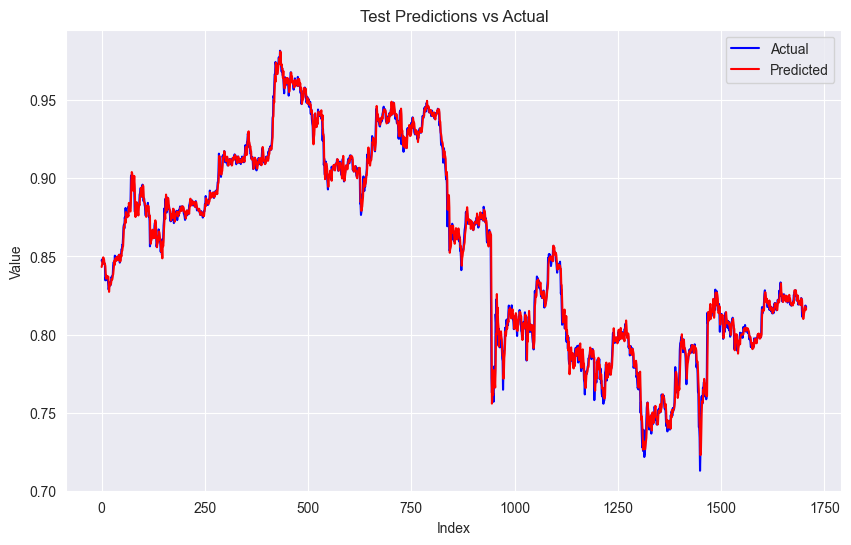

In [20]:
# Evaluation of Predictions
evaluate_predictions("Linear Regression Model", test_seq_y, y_pred_lin)

# Plot predictions
plot_predictions(test_seq_y, y_pred_lin)

<a id=3.1.2></a>
### 3.1.2 Random Forest Regression Model

In [26]:
# Generate sliding window data
train_seq_x, train_seq_y = sliding_window_generator(X_train, y_train, window_size=window_size, step_size=step_size,forecast_horizon=forecast_horizon)
val_seq_x, val_seq_y = sliding_window_generator(X_val, y_val,  window_size=window_size, step_size=step_size,forecast_horizon=forecast_horizon)
test_seq_x, test_seq_y = sliding_window_generator(X_test, y_test,  window_size=window_size, step_size=step_size,forecast_horizon=forecast_horizon)

# Initialize Random Forest regressor
rf_reg = RandomForestRegressor(
    n_estimators=50,
    max_depth=25,
    min_samples_split=15,
    min_samples_leaf=10,
    random_state=42
)

# Train the Random Forest model
rf_reg.fit(train_seq_x.reshape(len(train_seq_x), -1), train_seq_y.ravel())

# Make predictions on the test set
y_pred_rf = rf_reg.predict(test_seq_x.reshape(len(test_seq_x), -1))

Evaluation Metrics of Random Forest Regression Model:
----------------------------------------
Root Mean Squared Error (RMSE): 0.0063
Mean Absolute Error (MAE): 0.0042
R-squared (R2) Score: 0.9898


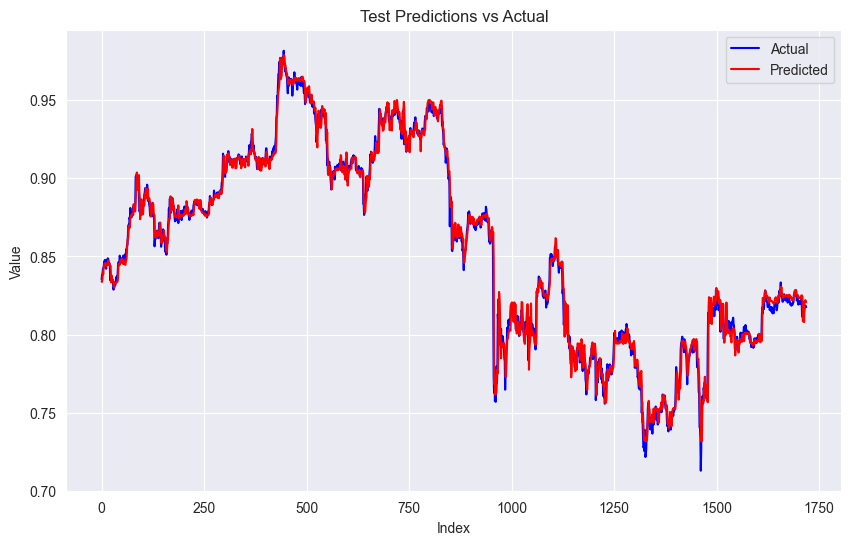

In [27]:
# Evaluation of Predictions
evaluate_predictions("Random Forest Regression Model", test_seq_y, y_pred_rf)

# Plot predictions
plot_predictions(test_seq_y, y_pred_rf)

<a id=3.1.3></a>
### 3.1.3 XGBoost Regression Model

In [21]:
# Generate sliding window data
train_seq_x, train_seq_y = sliding_window_generator(X_train, y_train, window_size=window_size, step_size=step_size,forecast_horizon=forecast_horizon)

val_seq_x, val_seq_y = sliding_window_generator(X_val, y_val,  window_size=window_size, step_size=step_size,forecast_horizon=forecast_horizon)

test_seq_x, test_seq_y = sliding_window_generator(X_test, y_test,  window_size=window_size, step_size=step_size,forecast_horizon=forecast_horizon)

# Initialize XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42,
                           early_stopping_rounds=25)

# Train the XGBoost model with early stopping based on the validation set
xgb_reg.fit(train_seq_x.reshape(len(train_seq_x), -1), train_seq_y,
             eval_set=[(val_seq_x.reshape(len(val_seq_x), -1), val_seq_y)], verbose=0)

# Make predictions on the test set
y_pred = xgb_reg.predict(test_seq_x.reshape(len(test_seq_x), -1))

Evaluation Metrics of XGBoost Regression Model:
----------------------------------------
Root Mean Squared Error (RMSE): 0.0112
Mean Absolute Error (MAE): 0.0082
R-squared (R2) Score: 0.9676


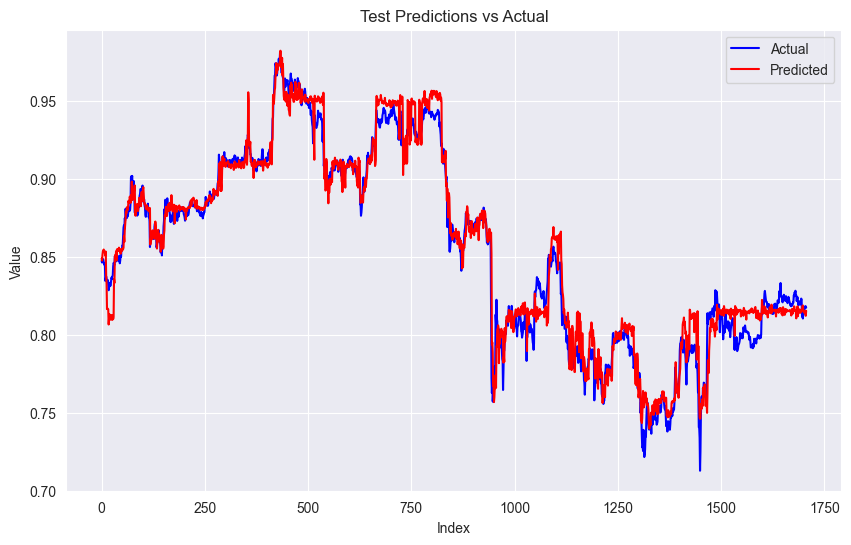

In [22]:
# Evaluation of Predictions
evaluate_predictions("XGBoost Regression Model", test_seq_y, y_pred)

# Plot predictions
plot_predictions(test_seq_y, y_pred)

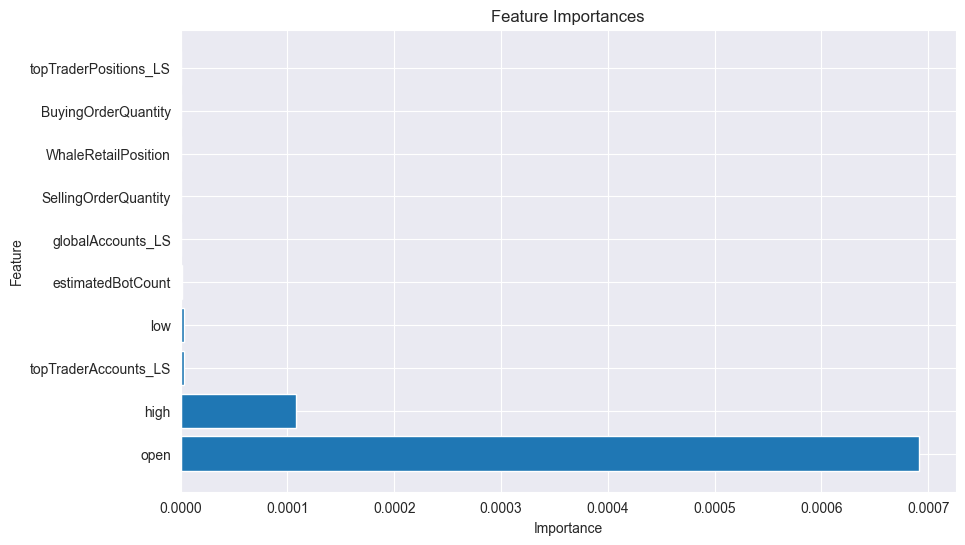

In [30]:
# Get feature names from X_test (assuming X_test is a pandas DataFrame)
feature_names = X_test.columns.tolist()

# Get feature importances and zip them with feature names
feature_importances = xgb_reg.feature_importances_
feature_importances_with_names = list(zip(feature_names, feature_importances))

# Sort feature importances by importance value
feature_importances_with_names.sort(key=lambda x: x[1], reverse=True)

# Visualize feature importances
importance_df = pd.DataFrame(feature_importances_with_names, columns=['Feature', 'Importance'])
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

<a id=3.2></a>
## 3.2 Traditional Forecasting Models

<a id=3.2.1></a>
### 3.2.1 SARIMAX (Seasonal Autoregressive Integrated Moving Average Exogenous) Model

In [37]:
# Get the best orders, including both non-seasonal and seasonal orders
stepwise_fit = auto_arima(y=y_train, seasonal=True)
best_order = stepwise_fit.order
best_seasonal_order = stepwise_fit.seasonal_order
print(f"Best order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")


KeyboardInterrupt



In [30]:
# Train the model
order = (2, 1, 4)  # Example non-seasonal orders (p, d, q)
seasonal_order = (0, 0, 0, 0)  # Example seasonal orders (P, D, Q, m)
model = SARIMAX(
        y_train,
        exog=X_train,
        order=order,
        seasonal_order=seasonal_order
    )
model = model.fit()

# Make predictions on the test data
y_test_pred = model.forecast(exog=X_test, steps=len(X_test))

Evaluation Metrics of SARIMAX Model:
----------------------------------------
Root Mean Squared Error (RMSE): 0.0267
Mean Absolute Error (MAE): 0.0228
R-squared (R2) Score: 0.8132


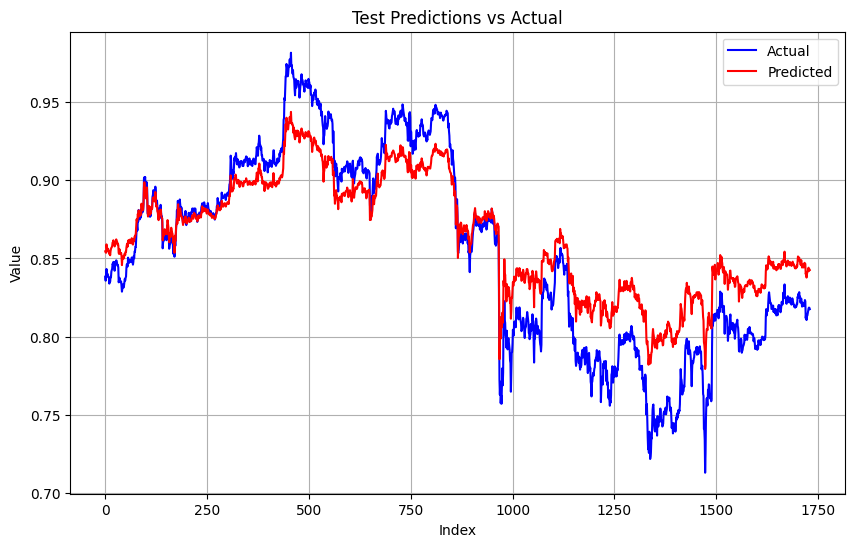

In [31]:
# Evaluation of predictions
evaluate_predictions("SARIMAX Model", y_test, y_test_pred)

# Plot predictions
plot_predictions(np.array(y_test), np.array(y_test_pred))

<a id=3.2.2 Prophet></a>
### 3.2.2 Prophet Model

In [31]:
# Copy original train_df to use further
prophet_df = train_df_original.copy()

In [32]:
# Preprocess the train data for prophet model
prophet_train = train_df_original.rename(columns={"close": "y"})
prophet_train["ds"] = train_df.index.tz_localize(None)
prophet_train.reset_index(drop=True, inplace=True)

# Use log-domain for prophet model
prophet_train["y_original"] = prophet_train["y"].copy()
prophet_train["y"] = np.log(prophet_train["y"])

# Display train data for prophet model
prophet_train.head(5)

,open,y,high,low,estimatedBotCount,globalAccounts_LS,topTraderAccounts_LS,topTraderPositions_LS,WhaleRetailPosition,BuyingOrderQuantity,SellingOrderQuantity,ds,y_original
0,28959.3,10.272883,29000.0,28930.8,48.0,1.2257,1.1286,1.1286,-0.17,4.311050e+07,5.464228e+07,2023-04-27 10:15:00,28937.2
1,28937.2,10.275286,29019.4,28937.0,44.0,1.2242,1.1281,1.1281,-0.12,5.897624e+07,3.443539e+07,2023-04-27 10:30:00,29006.8
2,29006.8,10.274427,29029.0,28943.0,65.0,1.2282,1.1299,1.1299,-0.23,5.094587e+07,5.778385e+07,2023-04-27 10:45:00,28981.9
3,28981.9,10.277723,29139.2,28960.0,53.0,1.2311,1.1299,1.1299,-0.30,2.054326e+08,1.598568e+08,2023-04-27 11:00:00,29077.6
4,29077.6,10.276268,29084.6,29025.4,119.0,1.2743,1.1515,1.1515,-1.24,6.229194e+07,8.039308e+07,2023-04-27 11:15:00,29035.3


In [33]:
# Build and train model
prophet_model = Prophet()

regressor_list = ['open', 'high', 'low', 'estimatedBotCount', 'globalAccounts_LS', 'topTraderAccounts_LS', 
                  'topTraderPositions_LS', 'WhaleRetailPosition', 'BuyingOrderQuantity', 'SellingOrderQuantity']

for regressor in regressor_list:
    prophet_model.add_regressor(regressor)

prophet_model.fit(prophet_train)

16:02:34 - cmdstanpy - INFO - Chain [1] start processing
16:03:02 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
# Preprocess the test data to use for Prophet model
prophet_df = pd.concat([prophet_df, test_df_original], ignore_index=False)
prophet_df = prophet_df.rename(columns={"close": "y"})
prophet_df["ds"] = prophet_df.index.tz_localize(None)
prophet_df.reset_index(drop=True, inplace=True)

# Create future data for Prophet model
future_data = prophet_model.make_future_dataframe(periods=96, freq="15min")
future_data = prophet_df[['open', 'high', 'low', 'estimatedBotCount', 'globalAccounts_LS', 'topTraderAccounts_LS', 
                          'topTraderPositions_LS', 'WhaleRetailPosition', 'BuyingOrderQuantity', 'SellingOrderQuantity', 
                          'ds']]

future_data.head(5)

,open,high,low,estimatedBotCount,globalAccounts_LS,topTraderAccounts_LS,topTraderPositions_LS,WhaleRetailPosition,BuyingOrderQuantity,SellingOrderQuantity,ds
0,28959.3,29000.0,28930.8,48.0,1.2257,1.1286,1.1286,-0.17,4.311050e+07,5.464228e+07,2023-04-27 10:15:00
1,28937.2,29019.4,28937.0,44.0,1.2242,1.1281,1.1281,-0.12,5.897624e+07,3.443539e+07,2023-04-27 10:30:00
2,29006.8,29029.0,28943.0,65.0,1.2282,1.1299,1.1299,-0.23,5.094587e+07,5.778385e+07,2023-04-27 10:45:00
3,28981.9,29139.2,28960.0,53.0,1.2311,1.1299,1.1299,-0.30,2.054326e+08,1.598568e+08,2023-04-27 11:00:00
4,29077.6,29084.6,29025.4,119.0,1.2743,1.1515,1.1515,-1.24,6.229194e+07,8.039308e+07,2023-04-27 11:15:00


In [35]:
# Forecasting with test data
prophet_forecast_data = prophet_model.predict(future_data)

# Display the last 5 predictions
prophet_forecast_data[['open', 'high', 'low', 'estimatedBotCount', 'globalAccounts_LS', 'topTraderAccounts_LS', 
               'topTraderPositions_LS', 'WhaleRetailPosition', 'BuyingOrderQuantity', 'SellingOrderQuantity', 
               'ds']].tail(5)

,open,high,low,estimatedBotCount,globalAccounts_LS,topTraderAccounts_LS,topTraderPositions_LS,WhaleRetailPosition,BuyingOrderQuantity,SellingOrderQuantity,ds
32860,-0.147828,0.327268,0.366257,-0.000011,-0.002163,-0.001322,-0.001322,-0.002117,0.000074,0.000201,2024-04-21 17:30:00
32861,-0.148259,0.328064,0.367491,0.000049,-0.001795,-0.001450,-0.001450,-0.002469,-0.000509,0.000524,2024-04-21 17:45:00
32862,-0.148623,0.327937,0.366065,-0.000132,-0.002054,-0.001350,-0.001350,-0.002323,-0.000420,-0.000147,2024-04-21 18:00:00
32863,-0.148760,0.327624,0.367168,-0.000078,-0.002446,-0.001307,-0.001307,-0.001959,-0.000619,0.000443,2024-04-21 18:15:00
32864,-0.148710,0.327514,0.367539,0.000103,-0.002465,-0.001364,-0.001364,-0.002081,-0.001142,0.000769,2024-04-21 18:30:00


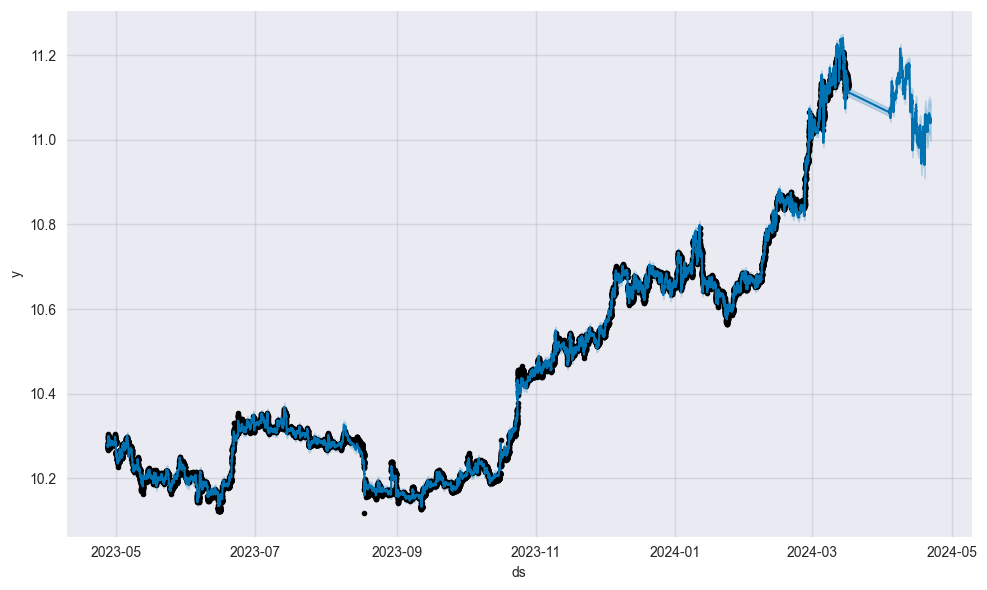

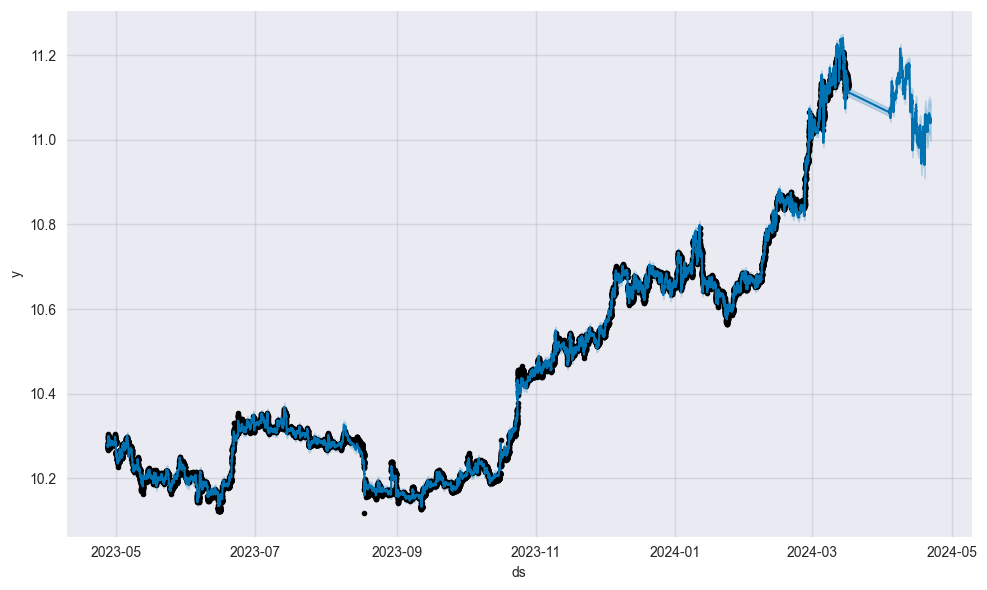

In [36]:
# Plot the information from Prophet model
prophet_model.plot(prophet_forecast_data)

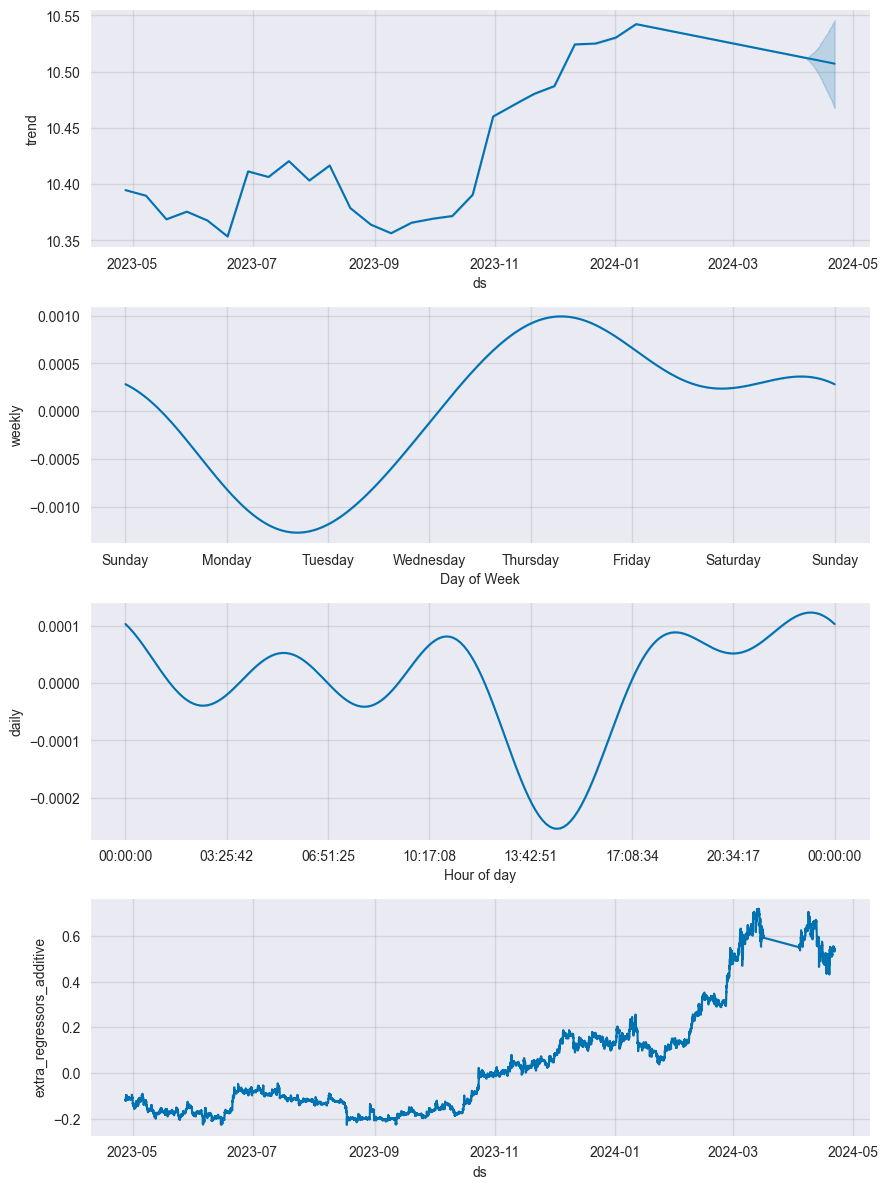

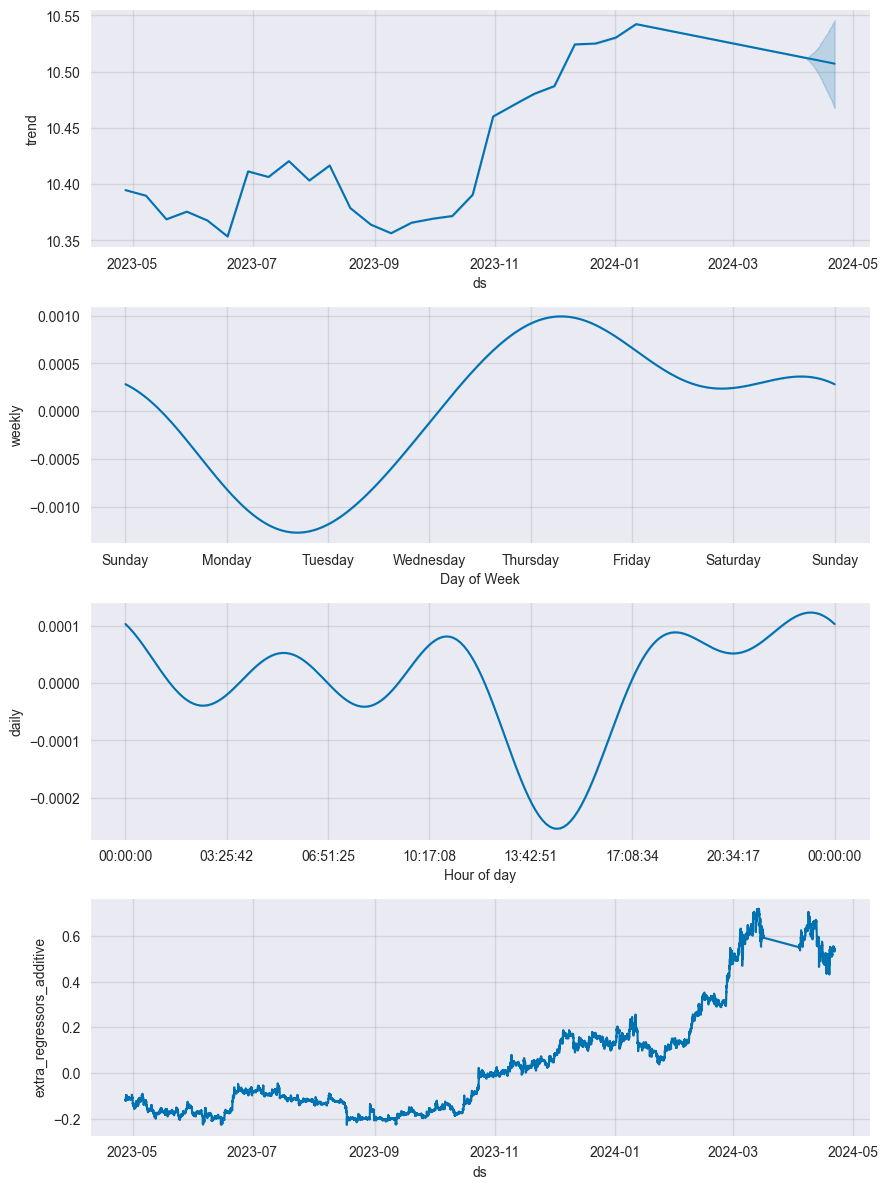

In [37]:
# Plot the Prophet model components
prophet_model.plot_components(prophet_forecast_data)

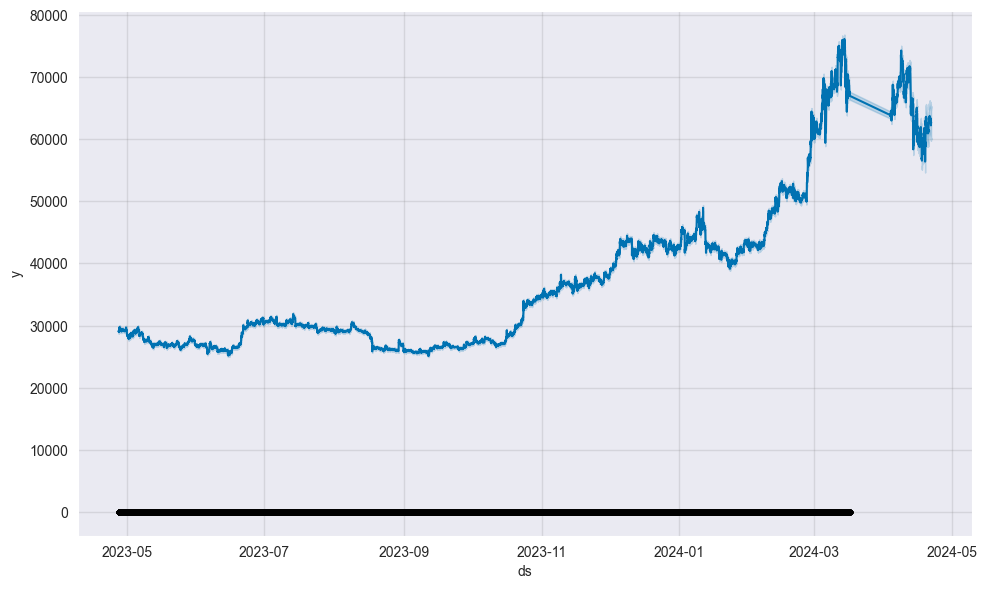

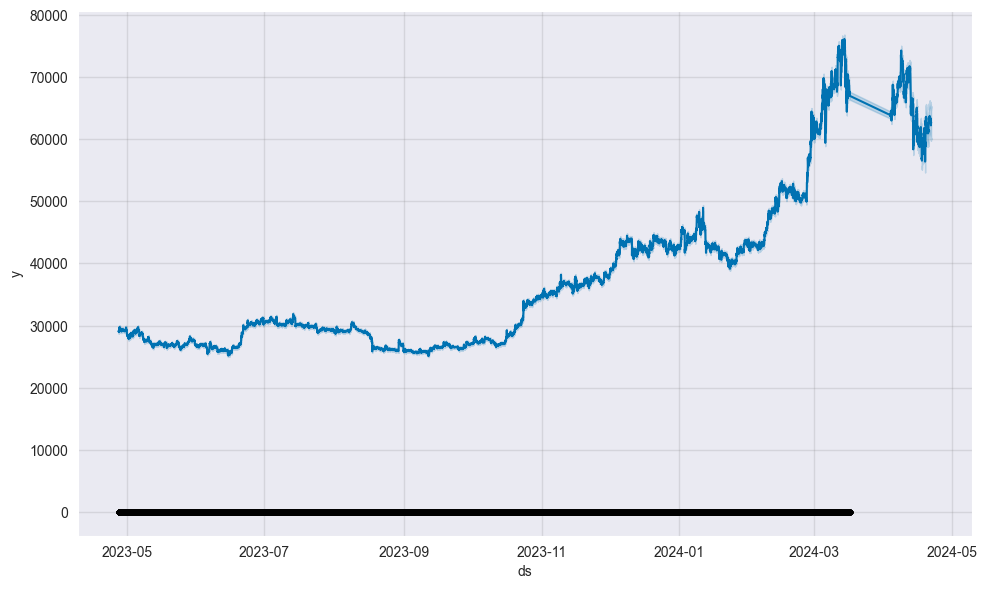

In [38]:
# Correct the log domain with exponential
prophet_forecast_data_original = prophet_forecast_data.copy()
prophet_forecast_data_original["yhat"] = np.exp(prophet_forecast_data_original["yhat"])
prophet_forecast_data_original["yhat_lower"] = np.exp(prophet_forecast_data_original["yhat_lower"])
prophet_forecast_data_original["yhat_upper"] = np.exp(prophet_forecast_data_original["yhat_upper"])
prophet_result_df = pd.DataFrame(prophet_forecast_data_original)

# Plot the exact prophet results without log domain
prophet_model.plot(prophet_forecast_data_original)

Evaluation Metrics of Prophet Model:
----------------------------------------
Root Mean Squared Error (RMSE): 1958.0558
Mean Absolute Error (MAE): 1953.9824
R-squared (R2) Score: -69.7868


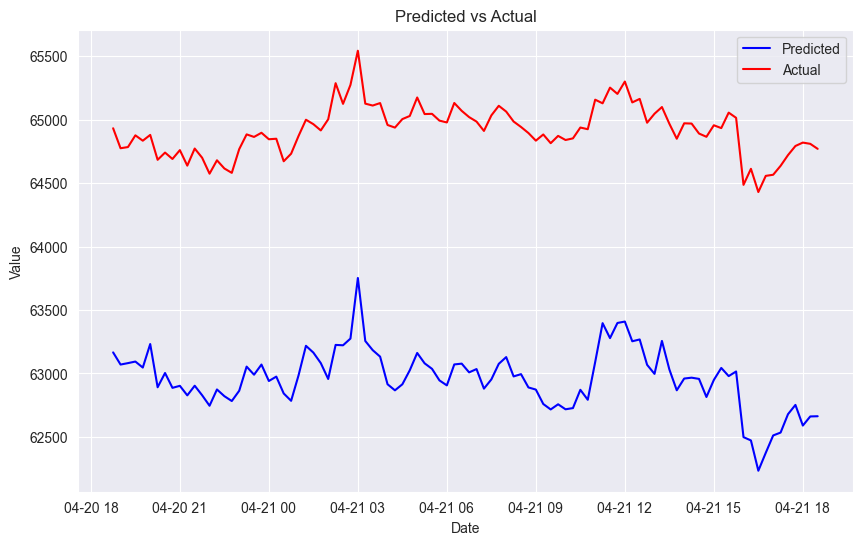

In [39]:
# Evaluation of predictions
evaluate_predictions("Prophet Model", prophet_result_df.iloc[-96:]["yhat"], test_df_original["close"].iloc[-96:])

# Plot the forecasting results of Prophet model
plt.figure(figsize=(10, 6))
plt.plot(prophet_result_df.iloc[-96:]["ds"], prophet_result_df.iloc[-96:]["yhat"], label="Predicted", color="blue")
plt.plot(prophet_result_df.iloc[-96:]["ds"], test_df_original["close"].iloc[-96:], label="Actual", color="red")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Predicted vs Actual")
plt.legend()
plt.show()

<a id=3.3></a>
## 3.3 Deep Learning Models

**Helper Functions for Torch Models**

In [23]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, early_stopping=None, num_epochs=200, device=None):
    """
    Train a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        criterion (callable): Loss function.
        optimizer (Optimizer): Optimizer for updating model parameters.
        scheduler (optional): Learning rate scheduler. Default is None.
        early_stopping (callable, optional): Early stopping function. Default is None.
        num_epochs (int, optional): Number of training epochs. Default is 200.
        device (torch.device, optional): Device to run the training process. If None, it will use CUDA if available, otherwise CPU. Default is None.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
            val_loss /= len(val_loader.dataset)

        if scheduler is not None:
            scheduler.step(val_loss)

        if early_stopping is not None:
            if early_stopping(val_loss, model):
                break

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

def predict(model, dataloader, device=None):
    """
    Make predictions using a trained PyTorch model.

    Args:
        model (nn.Module): The trained PyTorch model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device, optional): Device to run the prediction process. If None, it will use CUDA if available, otherwise CPU. Default is None.

    Returns:
        list: List of predictions.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
    return predictions


class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_val_loss = np.Inf
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss <= self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = model
            self.counter = 0
            return False
        else :
            self.counter +=1
            if self.counter == self.patience:
                print("Early Stopping ...")
                return True


<a id=3.3.1></a>
### 3.3.1 LSTM-FCN

In [24]:
class LSTM_FCN_Model(nn.Module):
    def __init__(self, input_shape, num_classes, lstm_units=256, conv_filters=128, kernel_size=7):
        super(LSTM_FCN_Model, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.lstm_units = lstm_units
        self.conv_filters = conv_filters
        self.kernel_size = kernel_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_shape[-1], hidden_size=lstm_units, batch_first=True)
        self.dropout = nn.Dropout(0.25)

        # Convolutional layers
        self.conv1d = nn.Conv1d(input_shape[-1], conv_filters, kernel_size, padding=(kernel_size-1)//2)
        self.batchnorm = nn.BatchNorm1d(conv_filters)
        self.activation = nn.GELU()

        # Global average pooling layer
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)

        # Output layer
        self.fc = nn.Linear(lstm_units + conv_filters, num_classes)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])

        # Convolutional layers
        conv_out = self.conv1d(x.transpose(1, 2))
        conv_out = self.batchnorm(conv_out)
        conv_out = self.activation(conv_out)
        conv_out = self.global_avg_pooling(conv_out).squeeze(2)

        # Concatenate LSTM and Convolutional outputs
        combined_out = torch.cat([lstm_out, conv_out], dim=1)

        # Output layer
        output = self.fc(combined_out)

        return output

In [26]:
# Define parameters
input_shape = (window_size, 10)  # Define num_features
num_classes = 1  # regression problem
batch_size = 128
epochs = 100
learning_rate = 1e-3

# Generate sliding window data
train_seq_x, train_seq_y = sliding_window_generator(X_train, y_train, window_size, step_size)
val_seq_x, val_seq_y = sliding_window_generator(X_val, y_val, window_size, step_size)
test_seq_x, test_seq_y = sliding_window_generator(X_test, y_test, window_size, step_size)

# Convert sliding window data to PyTorch tensors
train_seq_x_tensor = torch.tensor(train_seq_x, dtype=torch.float32)
train_seq_y_tensor = torch.tensor(train_seq_y, dtype=torch.float32)
val_seq_x_tensor = torch.tensor(val_seq_x, dtype=torch.float32)
val_seq_y_tensor = torch.tensor(val_seq_y, dtype=torch.float32)
test_seq_x_tensor = torch.tensor(test_seq_x, dtype=torch.float32)
test_seq_y_tensor = torch.tensor(test_seq_y, dtype=torch.float32)


# Create DataLoader for train and validation data
train_dataset = TensorDataset(train_seq_x_tensor, train_seq_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_seq_x_tensor, val_seq_y_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_dataset = TensorDataset(test_seq_x_tensor, test_seq_y_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Initialize and build the model
model = LSTM_FCN_Model(input_shape, num_classes)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5, min_lr=1e-8)
early_stopping = EarlyStopping(patience=21)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, early_stopping=early_stopping, num_epochs=epochs)


Epoch 1/100: 100%|██████████| 244/244 [00:01<00:00, 174.98batch/s]


Epoch 1/100, Train Loss: 0.0030, Val Loss: 0.0003


Epoch 2/100: 100%|██████████| 244/244 [00:01<00:00, 208.38batch/s]


Epoch 2/100, Train Loss: 0.0007, Val Loss: 0.0006


Epoch 3/100: 100%|██████████| 244/244 [00:01<00:00, 209.36batch/s]


Epoch 3/100, Train Loss: 0.0007, Val Loss: 0.0447


Epoch 4/100: 100%|██████████| 244/244 [00:01<00:00, 208.85batch/s]


Epoch 4/100, Train Loss: 0.0006, Val Loss: 0.0006


Epoch 5/100: 100%|██████████| 244/244 [00:01<00:00, 205.09batch/s]


Epoch 5/100, Train Loss: 0.0003, Val Loss: 0.0005


Epoch 6/100: 100%|██████████| 244/244 [00:01<00:00, 190.28batch/s]


Epoch 6/100, Train Loss: 0.0003, Val Loss: 0.0002


Epoch 7/100: 100%|██████████| 244/244 [00:01<00:00, 190.02batch/s]


Epoch 7/100, Train Loss: 0.0002, Val Loss: 0.0002


Epoch 8/100: 100%|██████████| 244/244 [00:01<00:00, 203.50batch/s]


Epoch 8/100, Train Loss: 0.0002, Val Loss: 0.0001


Epoch 9/100: 100%|██████████| 244/244 [00:01<00:00, 209.00batch/s]


Epoch 9/100, Train Loss: 0.0002, Val Loss: 0.0023


Epoch 10/100: 100%|██████████| 244/244 [00:01<00:00, 217.31batch/s]


Epoch 10/100, Train Loss: 0.0002, Val Loss: 0.0001


Epoch 11/100: 100%|██████████| 244/244 [00:01<00:00, 199.84batch/s]


Epoch 11/100, Train Loss: 0.0001, Val Loss: 0.0028


Epoch 12/100: 100%|██████████| 244/244 [00:01<00:00, 215.49batch/s]


Epoch 12/100, Train Loss: 0.0001, Val Loss: 0.0039


Epoch 13/100: 100%|██████████| 244/244 [00:01<00:00, 210.69batch/s]


Epoch 13/100, Train Loss: 0.0002, Val Loss: 0.0032


Epoch 14/100: 100%|██████████| 244/244 [00:01<00:00, 211.98batch/s]


Epoch 14/100, Train Loss: 0.0001, Val Loss: 0.0011


Epoch 15/100: 100%|██████████| 244/244 [00:01<00:00, 227.09batch/s]


Epoch 15/100, Train Loss: 0.0001, Val Loss: 0.0002


Epoch 16/100: 100%|██████████| 244/244 [00:01<00:00, 226.37batch/s]


Epoch 16/100, Train Loss: 0.0001, Val Loss: 0.0007


Epoch 17/100: 100%|██████████| 244/244 [00:01<00:00, 222.39batch/s]


Epoch 17/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 18/100: 100%|██████████| 244/244 [00:01<00:00, 214.59batch/s]


Epoch 18/100, Train Loss: 0.0001, Val Loss: 0.0002


Epoch 19/100: 100%|██████████| 244/244 [00:01<00:00, 213.43batch/s]


Epoch 19/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 20/100: 100%|██████████| 244/244 [00:01<00:00, 205.70batch/s]


Epoch 20/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 21/100: 100%|██████████| 244/244 [00:01<00:00, 200.64batch/s]


Epoch 21/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 22/100: 100%|██████████| 244/244 [00:01<00:00, 206.24batch/s]


Epoch 22/100, Train Loss: 0.0001, Val Loss: 0.0008


Epoch 23/100: 100%|██████████| 244/244 [00:01<00:00, 204.97batch/s]


Epoch 23/100, Train Loss: 0.0001, Val Loss: 0.0003


Epoch 24/100: 100%|██████████| 244/244 [00:01<00:00, 181.94batch/s]


Epoch 24/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 25/100: 100%|██████████| 244/244 [00:01<00:00, 218.46batch/s]


Epoch 25/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 26/100: 100%|██████████| 244/244 [00:01<00:00, 216.18batch/s]


Epoch 26/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 27/100: 100%|██████████| 244/244 [00:01<00:00, 221.98batch/s]


Epoch 27/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 28/100: 100%|██████████| 244/244 [00:01<00:00, 222.78batch/s]


Epoch 28/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 29/100: 100%|██████████| 244/244 [00:01<00:00, 221.47batch/s]


Epoch 29/100, Train Loss: 0.0001, Val Loss: 0.0002


Epoch 30/100: 100%|██████████| 244/244 [00:01<00:00, 193.28batch/s]


Epoch 30/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 31/100: 100%|██████████| 244/244 [00:01<00:00, 188.95batch/s]


Epoch 31/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 32/100: 100%|██████████| 244/244 [00:01<00:00, 193.06batch/s]


Epoch 32/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 33/100: 100%|██████████| 244/244 [00:01<00:00, 188.52batch/s]


Epoch 33/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 34/100: 100%|██████████| 244/244 [00:01<00:00, 197.21batch/s]


Epoch 34/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 35/100: 100%|██████████| 244/244 [00:01<00:00, 204.55batch/s]


Epoch 35/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 36/100: 100%|██████████| 244/244 [00:01<00:00, 195.92batch/s]


Epoch 36/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 37/100: 100%|██████████| 244/244 [00:01<00:00, 198.00batch/s]


Epoch 37/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 38/100: 100%|██████████| 244/244 [00:01<00:00, 214.17batch/s]


Epoch 38/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 39/100: 100%|██████████| 244/244 [00:01<00:00, 211.60batch/s]


Epoch 39/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 40/100: 100%|██████████| 244/244 [00:01<00:00, 215.25batch/s]


Epoch 40/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 41/100: 100%|██████████| 244/244 [00:01<00:00, 205.40batch/s]


Epoch 41/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 42/100: 100%|██████████| 244/244 [00:01<00:00, 210.46batch/s]


Epoch 42/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 43/100: 100%|██████████| 244/244 [00:01<00:00, 212.15batch/s]


Epoch 43/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 44/100: 100%|██████████| 244/244 [00:01<00:00, 214.38batch/s]


Epoch 44/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 45/100: 100%|██████████| 244/244 [00:01<00:00, 208.83batch/s]


Epoch 45/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 46/100: 100%|██████████| 244/244 [00:01<00:00, 203.33batch/s]


Epoch 46/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 47/100: 100%|██████████| 244/244 [00:01<00:00, 201.58batch/s]


Epoch 47/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 48/100: 100%|██████████| 244/244 [00:01<00:00, 210.78batch/s]


Epoch 48/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 49/100: 100%|██████████| 244/244 [00:01<00:00, 203.56batch/s]


Epoch 49/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 50/100: 100%|██████████| 244/244 [00:01<00:00, 206.50batch/s]


Epoch 50/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 51/100: 100%|██████████| 244/244 [00:01<00:00, 214.23batch/s]


Epoch 51/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 52/100: 100%|██████████| 244/244 [00:01<00:00, 231.82batch/s]


Epoch 52/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 53/100: 100%|██████████| 244/244 [00:01<00:00, 227.55batch/s]


Epoch 53/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 54/100: 100%|██████████| 244/244 [00:01<00:00, 227.95batch/s]


Epoch 54/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 55/100: 100%|██████████| 244/244 [00:01<00:00, 226.87batch/s]


Epoch 55/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 56/100: 100%|██████████| 244/244 [00:01<00:00, 227.42batch/s]


Epoch 56/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 57/100: 100%|██████████| 244/244 [00:01<00:00, 223.00batch/s]


Epoch 57/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 58/100: 100%|██████████| 244/244 [00:01<00:00, 204.86batch/s]


Epoch 58/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 59/100: 100%|██████████| 244/244 [00:01<00:00, 204.85batch/s]


Epoch 59/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 60/100: 100%|██████████| 244/244 [00:01<00:00, 196.49batch/s]


Epoch 60/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 61/100: 100%|██████████| 244/244 [00:01<00:00, 197.16batch/s]


Epoch 61/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 62/100: 100%|██████████| 244/244 [00:01<00:00, 192.21batch/s]


Epoch 62/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 63/100: 100%|██████████| 244/244 [00:01<00:00, 196.72batch/s]


Epoch 63/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 64/100: 100%|██████████| 244/244 [00:01<00:00, 189.59batch/s]


Epoch 64/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 65/100: 100%|██████████| 244/244 [00:01<00:00, 207.30batch/s]


Epoch 65/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 66/100: 100%|██████████| 244/244 [00:01<00:00, 207.75batch/s]


Epoch 66/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 67/100: 100%|██████████| 244/244 [00:01<00:00, 208.83batch/s]


Epoch 67/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 68/100: 100%|██████████| 244/244 [00:01<00:00, 210.48batch/s]


Epoch 68/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 69/100: 100%|██████████| 244/244 [00:01<00:00, 207.70batch/s]


Epoch 69/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 70/100: 100%|██████████| 244/244 [00:01<00:00, 209.66batch/s]


Epoch 70/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 71/100: 100%|██████████| 244/244 [00:01<00:00, 210.23batch/s]


Epoch 71/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 72/100: 100%|██████████| 244/244 [00:01<00:00, 191.79batch/s]


Epoch 72/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 73/100: 100%|██████████| 244/244 [00:01<00:00, 193.52batch/s]


Epoch 73/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 74/100: 100%|██████████| 244/244 [00:01<00:00, 205.49batch/s]


Epoch 74/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 75/100: 100%|██████████| 244/244 [00:01<00:00, 203.23batch/s]


Epoch 75/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 76/100: 100%|██████████| 244/244 [00:01<00:00, 206.29batch/s]


Epoch 76/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 77/100: 100%|██████████| 244/244 [00:01<00:00, 206.50batch/s]


Epoch 77/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 78/100: 100%|██████████| 244/244 [00:01<00:00, 207.00batch/s]


Epoch 78/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 79/100: 100%|██████████| 244/244 [00:01<00:00, 228.54batch/s]


Epoch 79/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 80/100: 100%|██████████| 244/244 [00:01<00:00, 227.07batch/s]


Epoch 80/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 81/100: 100%|██████████| 244/244 [00:01<00:00, 225.42batch/s]


Epoch 81/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 82/100: 100%|██████████| 244/244 [00:01<00:00, 227.09batch/s]


Epoch 82/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 83/100: 100%|██████████| 244/244 [00:01<00:00, 224.83batch/s]


Epoch 83/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 84/100: 100%|██████████| 244/244 [00:01<00:00, 220.83batch/s]


Epoch 84/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 85/100: 100%|██████████| 244/244 [00:01<00:00, 217.07batch/s]


Epoch 85/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 86/100: 100%|██████████| 244/244 [00:01<00:00, 202.26batch/s]


Epoch 86/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 87/100: 100%|██████████| 244/244 [00:01<00:00, 208.50batch/s]


Epoch 87/100, Train Loss: 0.0001, Val Loss: 0.0001


Epoch 88/100: 100%|██████████| 244/244 [00:01<00:00, 206.54batch/s]


Epoch 88/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 89/100: 100%|██████████| 244/244 [00:01<00:00, 204.09batch/s]


Epoch 89/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 90/100: 100%|██████████| 244/244 [00:01<00:00, 197.97batch/s]


Epoch 90/100, Train Loss: 0.0001, Val Loss: 0.0000


Epoch 91/100: 100%|██████████| 244/244 [00:01<00:00, 208.81batch/s]

Early Stopping ...


In [27]:
# Evaluate the model
test_preds = predict(model, test_loader)

Evaluation Metrics of LSTM-FCN Model:
----------------------------------------
Root Mean Squared Error (RMSE): 0.0075
Mean Absolute Error (MAE): 0.0058
R-squared (R2) Score: 0.9855


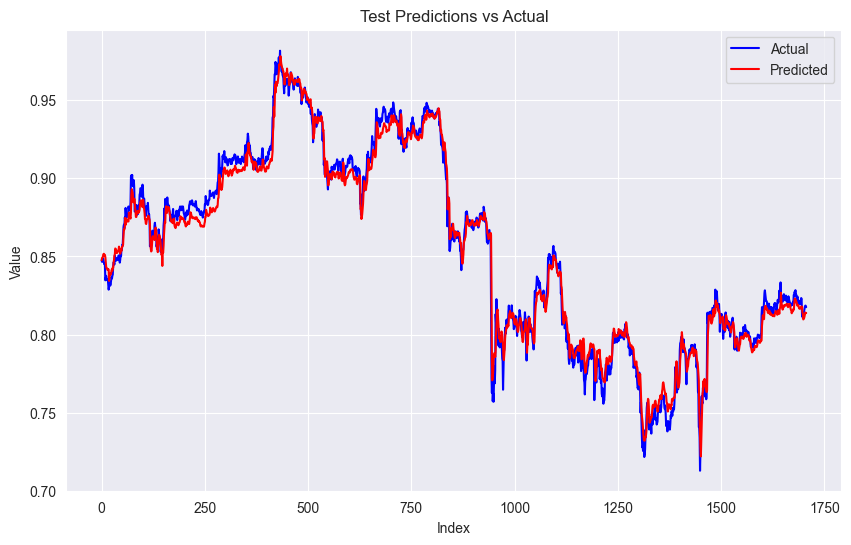

In [28]:
# Evaluation of predictions
evaluate_predictions("LSTM-FCN Model", test_seq_y, test_preds)

# Plot the predictions
plot_predictions(test_seq_y, test_preds)

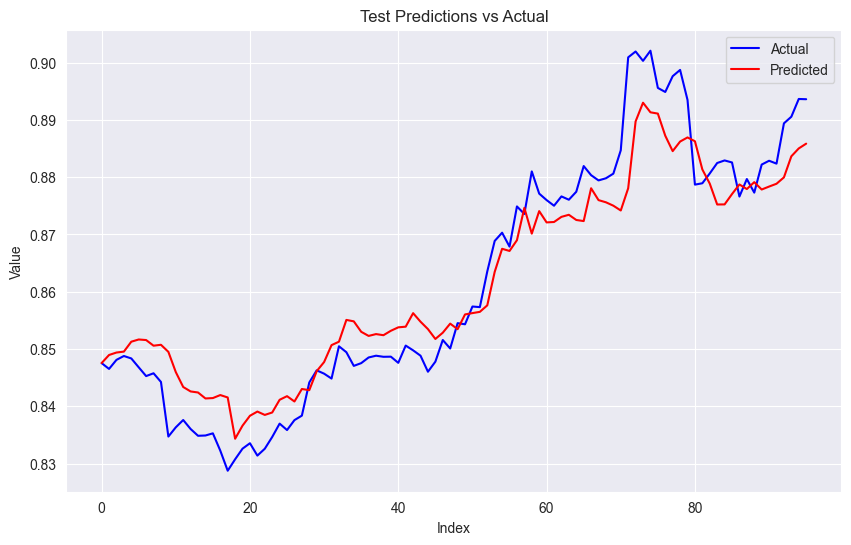

In [29]:
# First days prediction
plot_predictions(test_seq_y[:96], test_preds[:96])

<a id=3.3.2></a>
### 3.3.2 FCN

In [30]:
class FCN(nn.Module):
    def __init__(self, input_shape, layers=[64, 128, 256], kss=[7, 5, 3]):
        super(FCN, self).__init__()
        assert len(layers) == len(kss)

        self.convblock1 = self.conv_block(input_shape[-2], layers[0], kss[0])
        self.convblock2 = self.conv_block(layers[0], layers[1], kss[1])
        self.convblock3 = self.conv_block(layers[1], layers[2], kss[2])
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(layers[-1], 1)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.gap(x).squeeze(2)
        return self.fc(x)

    def conv_block(self, in_channels, filters, kernel_size):
        conv = nn.Conv1d(in_channels, filters, kernel_size, padding=(kernel_size-1)//2)
        batchnorm = nn.BatchNorm1d(filters)
        return nn.Sequential(conv, nn.ReLU(), batchnorm)

In [31]:
# Initialize and build the model
model = FCN(input_shape)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5, min_lr=1e-8)
early_stopping = EarlyStopping(patience=21)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, early_stopping=early_stopping, num_epochs=epochs)


Epoch 1/100: 100%|██████████| 244/244 [00:00<00:00, 285.00batch/s]


Epoch 1/100, Train Loss: 0.0080, Val Loss: 0.0003


Epoch 2/100: 100%|██████████| 244/244 [00:00<00:00, 297.39batch/s]


Epoch 2/100, Train Loss: 0.0006, Val Loss: 0.0012


Epoch 3/100: 100%|██████████| 244/244 [00:00<00:00, 295.41batch/s]


Epoch 3/100, Train Loss: 0.0005, Val Loss: 0.0010


Epoch 4/100: 100%|██████████| 244/244 [00:00<00:00, 280.19batch/s]


Epoch 4/100, Train Loss: 0.0005, Val Loss: 0.0004


Epoch 5/100: 100%|██████████| 244/244 [00:00<00:00, 294.31batch/s]


Epoch 5/100, Train Loss: 0.0005, Val Loss: 0.0002


Epoch 6/100: 100%|██████████| 244/244 [00:00<00:00, 285.23batch/s]


Epoch 6/100, Train Loss: 0.0004, Val Loss: 0.0002


Epoch 7/100: 100%|██████████| 244/244 [00:00<00:00, 290.90batch/s]


Epoch 7/100, Train Loss: 0.0005, Val Loss: 0.0002


Epoch 8/100: 100%|██████████| 244/244 [00:00<00:00, 285.14batch/s]


Epoch 8/100, Train Loss: 0.0005, Val Loss: 0.0004


Epoch 9/100: 100%|██████████| 244/244 [00:00<00:00, 282.26batch/s]


Epoch 9/100, Train Loss: 0.0005, Val Loss: 0.0006


Epoch 10/100: 100%|██████████| 244/244 [00:00<00:00, 268.70batch/s]


Epoch 10/100, Train Loss: 0.0005, Val Loss: 0.0003


Epoch 11/100: 100%|██████████| 244/244 [00:00<00:00, 266.96batch/s]


Epoch 11/100, Train Loss: 0.0005, Val Loss: 0.0005


Epoch 12/100: 100%|██████████| 244/244 [00:00<00:00, 268.85batch/s]


Epoch 12/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 13/100: 100%|██████████| 244/244 [00:00<00:00, 289.23batch/s]


Epoch 13/100, Train Loss: 0.0005, Val Loss: 0.0003


Epoch 14/100: 100%|██████████| 244/244 [00:00<00:00, 258.48batch/s]


Epoch 14/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 15/100: 100%|██████████| 244/244 [00:00<00:00, 267.16batch/s]


Epoch 15/100, Train Loss: 0.0004, Val Loss: 0.0004


Epoch 16/100: 100%|██████████| 244/244 [00:00<00:00, 278.51batch/s]


Epoch 16/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 17/100: 100%|██████████| 244/244 [00:00<00:00, 277.09batch/s]


Epoch 17/100, Train Loss: 0.0005, Val Loss: 0.0002


Epoch 18/100: 100%|██████████| 244/244 [00:00<00:00, 284.23batch/s]


Epoch 18/100, Train Loss: 0.0004, Val Loss: 0.0005


Epoch 19/100: 100%|██████████| 244/244 [00:00<00:00, 280.09batch/s]


Epoch 19/100, Train Loss: 0.0004, Val Loss: 0.0002


Epoch 20/100: 100%|██████████| 244/244 [00:00<00:00, 298.79batch/s]


Epoch 20/100, Train Loss: 0.0003, Val Loss: 0.0003


Epoch 21/100: 100%|██████████| 244/244 [00:00<00:00, 316.94batch/s]


Epoch 21/100, Train Loss: 0.0004, Val Loss: 0.0007


Epoch 22/100: 100%|██████████| 244/244 [00:00<00:00, 309.82batch/s]


Epoch 22/100, Train Loss: 0.0003, Val Loss: 0.0003


Epoch 23/100: 100%|██████████| 244/244 [00:00<00:00, 313.46batch/s]


Epoch 23/100, Train Loss: 0.0004, Val Loss: 0.0002


Epoch 24/100: 100%|██████████| 244/244 [00:00<00:00, 309.48batch/s]


Epoch 24/100, Train Loss: 0.0004, Val Loss: 0.0005


Epoch 25/100: 100%|██████████| 244/244 [00:00<00:00, 307.65batch/s]


Epoch 25/100, Train Loss: 0.0004, Val Loss: 0.0002


Epoch 26/100: 100%|██████████| 244/244 [00:00<00:00, 293.53batch/s]


Epoch 26/100, Train Loss: 0.0003, Val Loss: 0.0004


Epoch 27/100: 100%|██████████| 244/244 [00:00<00:00, 293.60batch/s]


Epoch 27/100, Train Loss: 0.0005, Val Loss: 0.0003


Epoch 28/100: 100%|██████████| 244/244 [00:00<00:00, 286.18batch/s]


Epoch 28/100, Train Loss: 0.0004, Val Loss: 0.0011


Epoch 29/100: 100%|██████████| 244/244 [00:00<00:00, 280.86batch/s]


Epoch 29/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 30/100: 100%|██████████| 244/244 [00:00<00:00, 285.65batch/s]


Epoch 30/100, Train Loss: 0.0004, Val Loss: 0.0002


Epoch 31/100: 100%|██████████| 244/244 [00:00<00:00, 292.84batch/s]


Epoch 31/100, Train Loss: 0.0004, Val Loss: 0.0002


Epoch 32/100: 100%|██████████| 244/244 [00:00<00:00, 270.74batch/s]


Epoch 32/100, Train Loss: 0.0005, Val Loss: 0.0004


Epoch 33/100: 100%|██████████| 244/244 [00:00<00:00, 282.31batch/s]


Epoch 33/100, Train Loss: 0.0003, Val Loss: 0.0003


Epoch 34/100: 100%|██████████| 244/244 [00:00<00:00, 303.37batch/s]


Epoch 34/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 35/100: 100%|██████████| 244/244 [00:00<00:00, 309.35batch/s]


Epoch 35/100, Train Loss: 0.0004, Val Loss: 0.0002


Epoch 36/100: 100%|██████████| 244/244 [00:00<00:00, 308.92batch/s]


Epoch 36/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 37/100: 100%|██████████| 244/244 [00:00<00:00, 311.19batch/s]


Epoch 37/100, Train Loss: 0.0003, Val Loss: 0.0003


Epoch 38/100: 100%|██████████| 244/244 [00:00<00:00, 308.42batch/s]


Epoch 38/100, Train Loss: 0.0003, Val Loss: 0.0005


Epoch 39/100: 100%|██████████| 244/244 [00:00<00:00, 316.87batch/s]


Epoch 39/100, Train Loss: 0.0004, Val Loss: 0.0002


Epoch 40/100: 100%|██████████| 244/244 [00:00<00:00, 311.16batch/s]


Epoch 40/100, Train Loss: 0.0004, Val Loss: 0.0002


Epoch 41/100: 100%|██████████| 244/244 [00:00<00:00, 310.40batch/s]


Epoch 41/100, Train Loss: 0.0004, Val Loss: 0.0002


Epoch 42/100: 100%|██████████| 244/244 [00:00<00:00, 296.32batch/s]


Epoch 42/100, Train Loss: 0.0004, Val Loss: 0.0004


Epoch 43/100: 100%|██████████| 244/244 [00:00<00:00, 260.69batch/s]


Epoch 43/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 44/100: 100%|██████████| 244/244 [00:00<00:00, 276.69batch/s]


Epoch 44/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 45/100: 100%|██████████| 244/244 [00:00<00:00, 265.74batch/s]


Epoch 45/100, Train Loss: 0.0004, Val Loss: 0.0002


Epoch 46/100: 100%|██████████| 244/244 [00:00<00:00, 279.42batch/s]


Epoch 46/100, Train Loss: 0.0003, Val Loss: 0.0003


Epoch 47/100: 100%|██████████| 244/244 [00:00<00:00, 275.95batch/s]


Epoch 47/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 48/100: 100%|██████████| 244/244 [00:00<00:00, 281.88batch/s]


Epoch 48/100, Train Loss: 0.0004, Val Loss: 0.0004


Epoch 49/100: 100%|██████████| 244/244 [00:00<00:00, 278.07batch/s]


Epoch 49/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 50/100: 100%|██████████| 244/244 [00:00<00:00, 285.44batch/s]


Epoch 50/100, Train Loss: 0.0004, Val Loss: 0.0005


Epoch 51/100: 100%|██████████| 244/244 [00:00<00:00, 281.11batch/s]


Epoch 51/100, Train Loss: 0.0003, Val Loss: 0.0003


Epoch 52/100: 100%|██████████| 244/244 [00:00<00:00, 283.62batch/s]


Epoch 52/100, Train Loss: 0.0004, Val Loss: 0.0008


Epoch 53/100: 100%|██████████| 244/244 [00:00<00:00, 293.40batch/s]


Epoch 53/100, Train Loss: 0.0005, Val Loss: 0.0003


Epoch 54/100: 100%|██████████| 244/244 [00:00<00:00, 281.37batch/s]


Epoch 54/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 55/100: 100%|██████████| 244/244 [00:00<00:00, 284.94batch/s]


Epoch 55/100, Train Loss: 0.0003, Val Loss: 0.0002


Epoch 56/100: 100%|██████████| 244/244 [00:00<00:00, 278.80batch/s]


Epoch 56/100, Train Loss: 0.0004, Val Loss: 0.0002


Epoch 57/100: 100%|██████████| 244/244 [00:00<00:00, 294.94batch/s]


Epoch 57/100, Train Loss: 0.0004, Val Loss: 0.0002


Epoch 58/100: 100%|██████████| 244/244 [00:00<00:00, 284.58batch/s]


Epoch 58/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 59/100: 100%|██████████| 244/244 [00:00<00:00, 279.34batch/s]


Epoch 59/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 60/100: 100%|██████████| 244/244 [00:00<00:00, 270.24batch/s]


Epoch 60/100, Train Loss: 0.0004, Val Loss: 0.0003


Epoch 61/100: 100%|██████████| 244/244 [00:00<00:00, 266.33batch/s]


Epoch 61/100, Train Loss: 0.0003, Val Loss: 0.0004


Epoch 62/100: 100%|██████████| 244/244 [00:00<00:00, 280.66batch/s]

Early Stopping ...


In [32]:
# Evaluate the model
test_preds = predict(model, test_loader)

Evaluation Metrics of FCN Model:
----------------------------------------
Root Mean Squared Error (RMSE): 0.0194
Mean Absolute Error (MAE): 0.0141
R-squared (R2) Score: 0.9031


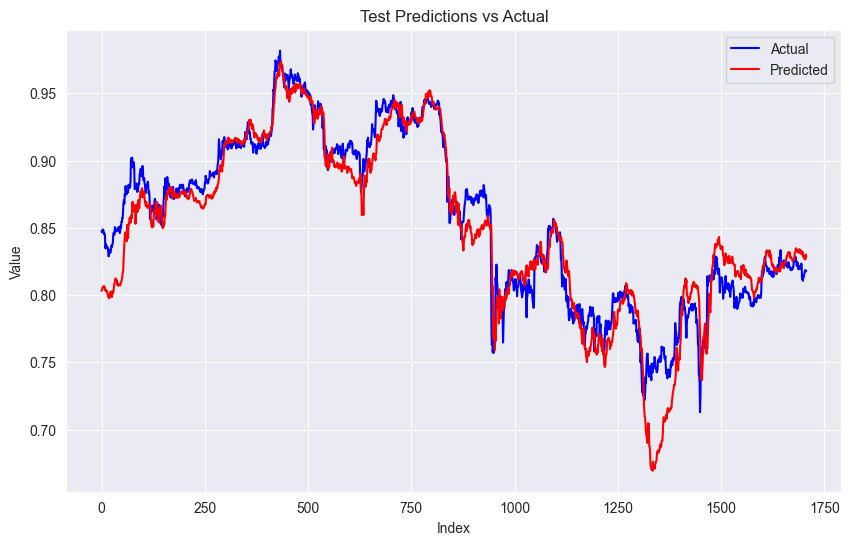

In [33]:
# Evaluation of predictions
evaluate_predictions("FCN Model", test_seq_y, test_preds)

# Plot predictions
plot_predictions(test_seq_y, test_preds)

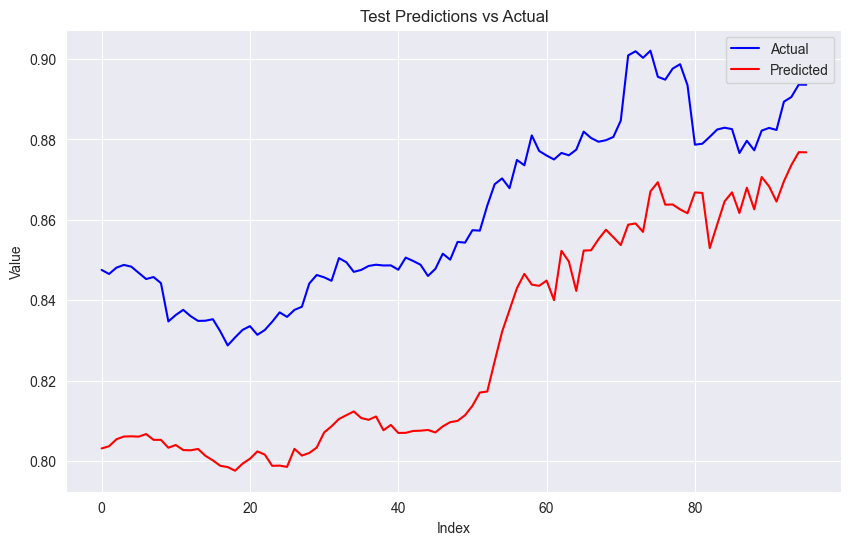

In [34]:
# First days prediction
plot_predictions(test_seq_y[:96], test_preds[:96])

<a id=3.3.4></a>
### 3.3.4 Transformer Model

In [35]:
class TransformerModel(Module):
    def __init__(self, c_in, c_out, d_model=64, n_head=1, d_ffn=128, dropout=0.1, activation="relu", n_layers=1):
        """
        Args:
            c_in: the number of features (aka variables, dimensions, channels) in the time series dataset
            c_out: the number of target classes
            d_model: total dimension of the model.
            nhead:  parallel attention heads.
            d_ffn: the dimension of the feedforward network model.
            dropout: a Dropout layer on attn_output_weights.
            activation: the activation function of intermediate layer, relu or gelu.
            num_layers: the number of sub-encoder-layers in the encoder.

        Input shape:
            bs (batch size) x nvars (aka variables, dimensions, channels) x seq_len (aka time steps)
            """
        self.inlinear = nn.Linear(c_in, d_model)
        self.relu = nn.ReLU()
        encoder_layer = TransformerEncoderLayer(d_model, n_head, dim_feedforward=d_ffn, dropout=dropout, activation=activation)
        encoder_norm = nn.LayerNorm(d_model)
        self.transformer_encoder = TransformerEncoder(encoder_layer, n_layers, norm=encoder_norm)
        self.transpose = Transpose(1, 0)
        self.max = Max(1)
        self.outlinear = nn.Linear(d_model, c_out)

    def forward(self,x):
        x = x.permute(dims=(1, 0, 2)) # bs x nvars x seq_len -> seq_len x bs x nvars
        x = self.inlinear(x) # seq_len x bs x nvars -> seq_len x bs x d_model
        x = self.relu(x)
        x = self.transformer_encoder(x)
        x = self.transpose(x) # seq_len x bs x d_model -> bs x seq_len x d_model
        x = self.max(x)
        x = self.relu(x)
        x = self.outlinear(x)
        return x

In [36]:
# Initialize and build the model
model = TransformerModel(10, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5, min_lr=1e-8)
early_stopping = EarlyStopping(patience=21)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=scheduler, early_stopping=early_stopping, num_epochs=epochs)


C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1/100:   0%|          | 0/244 [00:00<?, ?batch/s]C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch 1/100: 100%|██████████| 244/244 [00:01<00:00, 213.05batch/s]


Epoch 1/100, Train Loss: 0.0015, Val Loss: 0.0038


Epoch 2/100: 100%|██████████| 244/244 [00:01<00:00, 199.44batch/s]


Epoch 2/100, Train Loss: 0.0002, Val Loss: 0.0043


Epoch 3/100: 100%|██████████| 244/244 [00:01<00:00, 207.32batch/s]


Epoch 3/100, Train Loss: 0.0001, Val Loss: 0.0048


Epoch 4/100: 100%|██████████| 244/244 [00:01<00:00, 218.96batch/s]


Epoch 4/100, Train Loss: 0.0001, Val Loss: 0.0040


Epoch 5/100: 100%|██████████| 244/244 [00:01<00:00, 239.38batch/s]


Epoch 5/100, Train Loss: 0.0001, Val Loss: 0.0035


Epoch 6/100: 100%|██████████| 244/244 [00:01<00:00, 238.62batch/s]


Epoch 6/100, Train Loss: 0.0001, Val Loss: 0.0036


Epoch 7/100: 100%|██████████| 244/244 [00:01<00:00, 239.41batch/s]


Epoch 7/100, Train Loss: 0.0001, Val Loss: 0.0028


Epoch 8/100: 100%|██████████| 244/244 [00:01<00:00, 238.44batch/s]


Epoch 8/100, Train Loss: 0.0001, Val Loss: 0.0027


Epoch 9/100: 100%|██████████| 244/244 [00:01<00:00, 235.01batch/s]


Epoch 9/100, Train Loss: 0.0001, Val Loss: 0.0017


Epoch 10/100: 100%|██████████| 244/244 [00:01<00:00, 235.98batch/s]


Epoch 10/100, Train Loss: 0.0001, Val Loss: 0.0024


Epoch 11/100: 100%|██████████| 244/244 [00:01<00:00, 235.59batch/s]


Epoch 11/100, Train Loss: 0.0001, Val Loss: 0.0014


Epoch 12/100: 100%|██████████| 244/244 [00:01<00:00, 225.29batch/s]


Epoch 12/100, Train Loss: 0.0001, Val Loss: 0.0019


Epoch 13/100: 100%|██████████| 244/244 [00:01<00:00, 223.97batch/s]


Epoch 13/100, Train Loss: 0.0001, Val Loss: 0.0014


Epoch 14/100: 100%|██████████| 244/244 [00:01<00:00, 221.09batch/s]


Epoch 14/100, Train Loss: 0.0000, Val Loss: 0.0010


Epoch 15/100: 100%|██████████| 244/244 [00:01<00:00, 214.30batch/s]


Epoch 15/100, Train Loss: 0.0000, Val Loss: 0.0016


Epoch 16/100: 100%|██████████| 244/244 [00:01<00:00, 206.22batch/s]


Epoch 16/100, Train Loss: 0.0000, Val Loss: 0.0011


Epoch 17/100: 100%|██████████| 244/244 [00:01<00:00, 222.66batch/s]


Epoch 17/100, Train Loss: 0.0000, Val Loss: 0.0008


Epoch 18/100: 100%|██████████| 244/244 [00:01<00:00, 210.96batch/s]


Epoch 18/100, Train Loss: 0.0000, Val Loss: 0.0009


Epoch 19/100: 100%|██████████| 244/244 [00:01<00:00, 210.45batch/s]


Epoch 19/100, Train Loss: 0.0000, Val Loss: 0.0009


Epoch 20/100: 100%|██████████| 244/244 [00:01<00:00, 218.86batch/s]


Epoch 20/100, Train Loss: 0.0000, Val Loss: 0.0015


Epoch 21/100: 100%|██████████| 244/244 [00:01<00:00, 205.52batch/s]


Epoch 21/100, Train Loss: 0.0000, Val Loss: 0.0005


Epoch 22/100: 100%|██████████| 244/244 [00:01<00:00, 214.45batch/s]


Epoch 22/100, Train Loss: 0.0000, Val Loss: 0.0004


Epoch 23/100: 100%|██████████| 244/244 [00:01<00:00, 204.07batch/s]


Epoch 23/100, Train Loss: 0.0000, Val Loss: 0.0016


Epoch 24/100: 100%|██████████| 244/244 [00:01<00:00, 231.41batch/s]


Epoch 24/100, Train Loss: 0.0000, Val Loss: 0.0010


Epoch 25/100: 100%|██████████| 244/244 [00:01<00:00, 214.87batch/s]


Epoch 25/100, Train Loss: 0.0000, Val Loss: 0.0003


Epoch 26/100: 100%|██████████| 244/244 [00:01<00:00, 209.99batch/s]


Epoch 26/100, Train Loss: 0.0000, Val Loss: 0.0004


Epoch 27/100: 100%|██████████| 244/244 [00:01<00:00, 202.48batch/s]


Epoch 27/100, Train Loss: 0.0000, Val Loss: 0.0002


Epoch 28/100: 100%|██████████| 244/244 [00:01<00:00, 198.94batch/s]


Epoch 28/100, Train Loss: 0.0000, Val Loss: 0.0007


Epoch 29/100: 100%|██████████| 244/244 [00:01<00:00, 232.46batch/s]


Epoch 29/100, Train Loss: 0.0000, Val Loss: 0.0024


Epoch 30/100: 100%|██████████| 244/244 [00:01<00:00, 207.24batch/s]


Epoch 30/100, Train Loss: 0.0000, Val Loss: 0.0007


Epoch 31/100: 100%|██████████| 244/244 [00:01<00:00, 215.86batch/s]


Epoch 31/100, Train Loss: 0.0000, Val Loss: 0.0002


Epoch 32/100: 100%|██████████| 244/244 [00:01<00:00, 221.16batch/s]


Epoch 32/100, Train Loss: 0.0000, Val Loss: 0.0012


Epoch 33/100: 100%|██████████| 244/244 [00:01<00:00, 210.56batch/s]


Epoch 33/100, Train Loss: 0.0000, Val Loss: 0.0003


Epoch 34/100: 100%|██████████| 244/244 [00:01<00:00, 229.04batch/s]


Epoch 34/100, Train Loss: 0.0000, Val Loss: 0.0005


Epoch 35/100: 100%|██████████| 244/244 [00:01<00:00, 230.62batch/s]


Epoch 35/100, Train Loss: 0.0000, Val Loss: 0.0008


Epoch 36/100: 100%|██████████| 244/244 [00:01<00:00, 233.85batch/s]


Epoch 36/100, Train Loss: 0.0000, Val Loss: 0.0004


Epoch 37/100: 100%|██████████| 244/244 [00:01<00:00, 237.04batch/s]


Epoch 37/100, Train Loss: 0.0000, Val Loss: 0.0002


Epoch 38/100: 100%|██████████| 244/244 [00:01<00:00, 236.88batch/s]


Epoch 38/100, Train Loss: 0.0000, Val Loss: 0.0006


Epoch 39/100: 100%|██████████| 244/244 [00:01<00:00, 237.76batch/s]


Epoch 39/100, Train Loss: 0.0000, Val Loss: 0.0002


Epoch 40/100: 100%|██████████| 244/244 [00:01<00:00, 242.45batch/s]


Epoch 40/100, Train Loss: 0.0000, Val Loss: 0.0004


Epoch 41/100: 100%|██████████| 244/244 [00:01<00:00, 231.93batch/s]


Epoch 41/100, Train Loss: 0.0000, Val Loss: 0.0005


Epoch 42/100: 100%|██████████| 244/244 [00:01<00:00, 212.59batch/s]


Epoch 42/100, Train Loss: 0.0000, Val Loss: 0.0002


Epoch 43/100: 100%|██████████| 244/244 [00:01<00:00, 213.51batch/s]


Epoch 43/100, Train Loss: 0.0000, Val Loss: 0.0002


Epoch 44/100: 100%|██████████| 244/244 [00:01<00:00, 201.97batch/s]


Epoch 44/100, Train Loss: 0.0000, Val Loss: 0.0002


Epoch 45/100: 100%|██████████| 244/244 [00:01<00:00, 205.52batch/s]


Epoch 45/100, Train Loss: 0.0000, Val Loss: 0.0003


Epoch 46/100: 100%|██████████| 244/244 [00:01<00:00, 212.87batch/s]


Epoch 46/100, Train Loss: 0.0000, Val Loss: 0.0003


Epoch 47/100: 100%|██████████| 244/244 [00:01<00:00, 206.85batch/s]


Epoch 47/100, Train Loss: 0.0000, Val Loss: 0.0003


Epoch 48/100: 100%|██████████| 244/244 [00:01<00:00, 212.87batch/s]


Epoch 48/100, Train Loss: 0.0000, Val Loss: 0.0002


Epoch 49/100: 100%|██████████| 244/244 [00:01<00:00, 223.10batch/s]


Epoch 49/100, Train Loss: 0.0000, Val Loss: 0.0002


Epoch 50/100: 100%|██████████| 244/244 [00:01<00:00, 208.01batch/s]


Epoch 50/100, Train Loss: 0.0000, Val Loss: 0.0002


Epoch 51/100: 100%|██████████| 244/244 [00:01<00:00, 228.84batch/s]


Epoch 51/100, Train Loss: 0.0000, Val Loss: 0.0002


Epoch 52/100: 100%|██████████| 244/244 [00:01<00:00, 218.65batch/s]


Epoch 52/100, Train Loss: 0.0000, Val Loss: 0.0003


Epoch 53/100: 100%|██████████| 244/244 [00:01<00:00, 218.15batch/s]


Epoch 53/100, Train Loss: 0.0000, Val Loss: 0.0003


Epoch 54/100: 100%|██████████| 244/244 [00:01<00:00, 230.52batch/s]


Epoch 54/100, Train Loss: 0.0000, Val Loss: 0.0002


Epoch 55/100: 100%|██████████| 244/244 [00:01<00:00, 206.41batch/s]


Epoch 55/100, Train Loss: 0.0000, Val Loss: 0.0004


Epoch 56/100: 100%|██████████| 244/244 [00:01<00:00, 207.66batch/s]


Epoch 56/100, Train Loss: 0.0000, Val Loss: 0.0003


Epoch 57/100: 100%|██████████| 244/244 [00:01<00:00, 216.94batch/s]


Epoch 57/100, Train Loss: 0.0000, Val Loss: 0.0003


Epoch 58/100: 100%|██████████| 244/244 [00:01<00:00, 213.15batch/s]

Early Stopping ...


In [37]:
# Evaluate the model
test_preds = predict(model, test_loader)

Evaluation Metrics of Transformer Model:
----------------------------------------
Root Mean Squared Error (RMSE): 0.0149
Mean Absolute Error (MAE): 0.0115
R-squared (R2) Score: 0.9429


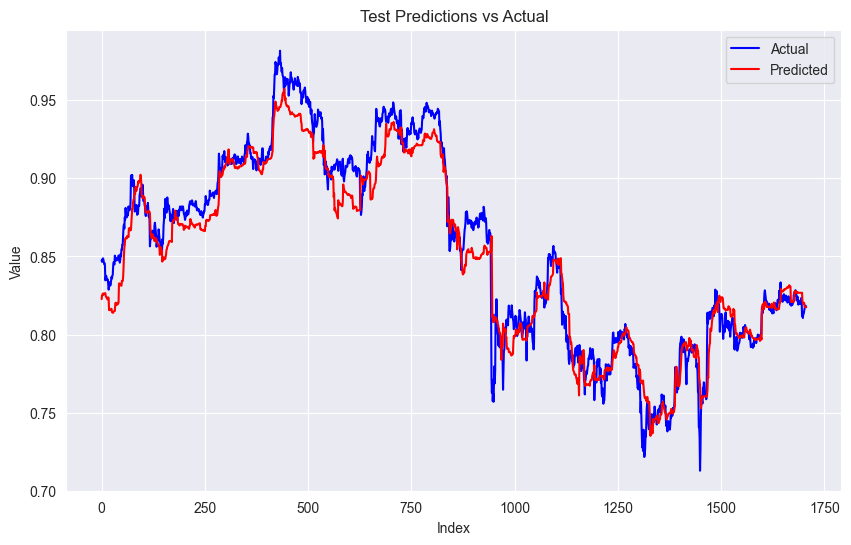

In [38]:
# Evaluation of predictions
evaluate_predictions("Transformer Model", test_seq_y, test_preds)

# Plot predictions
plot_predictions(test_seq_y, test_preds)

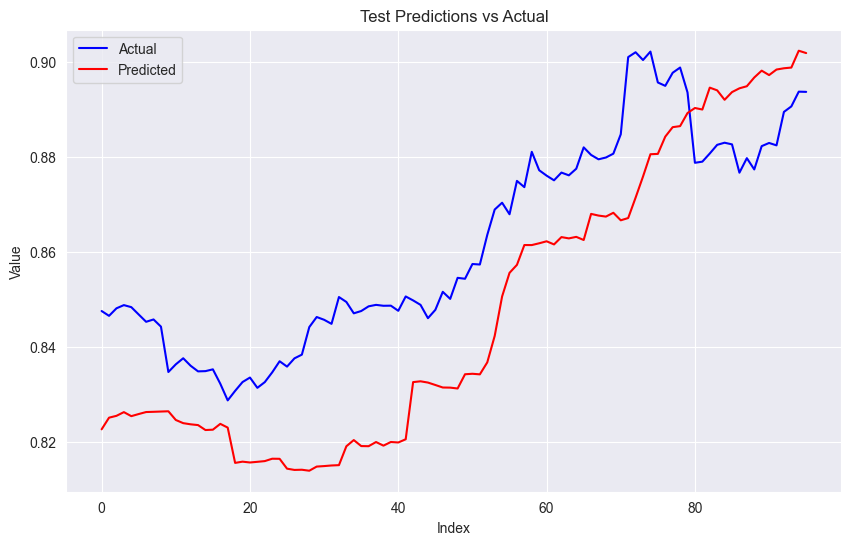

In [39]:
# First days prediction
plot_predictions(test_seq_y[:96], test_preds[:96])